## Описание проекта

В данном проекте я буду анализировать датасет Superstore Sales с платформы Kaggle (https://www.kaggle.com/datasets/ishanshrivastava28/superstore-sales/data). Я проанализирую, от каких регионов и категорий товаров бизнес получает больше всего продаж, выручки, прибыли и исходя из этого сделаю гипотезы, как можно положительно повлиять на эти показатели.

Используемые технологии:
- веб-скреппинг с помощью scrapy (код для скреппинга писал отдельно в пайчарме, файлы, которые использовались в процессе прикрепил на гитхаб)
- обработка данных с помощью Pandas
- работа с геоданными (GeoPandas)
- визуализация данных (matplotlib, seaborn, geopandas, feature importance из lgbm)
- машинное обучение (бустинг из LGBM)
- дополнительные технологии (LGBM, optuna, seaborn)

## Выгружаем данные и импортируем библиотеки

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import plotly.express as px
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import warnings

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv(r'Superstore.csv', encoding='windows-1252')
# взял датасет с кэггла https://www.kaggle.com/datasets/ishanshrivastava28/superstore-sales/data

coords = pd.read_csv('coords_parser.csv')
# спарсил координаты городов из википедии, файлы с кодом для парсинга на гитхабе.

In [3]:
coords.loc[len(coords)] = ['Nebraska', 42, 100]
coords.sort_values(by='state', inplace = True)
# добавил штат Небраска руками, потому что на википедии нет координат штата в том же стиле, что у других штатов

## Описание датасета

1) Order ID: Номер заказа
2) Order Date: Дата получения заказа
3) Ship Date: Дата отргузки заказа
4) Ship Mode: Тип доставки
5) Customer ID: Номер покупателя
6) Segment: Тип покупателя (Компания, физическое лицо..)
7) Country: Страна, в которую был сделан заказ (Везде США)
8) City: Город, в который был сделан заказ
9) State: Штат, в которой был сделан заказ
10) Postal Code: Почтовый индекс
11) Region: В какой части США находится клиент (Запад, Восток, Юг, Север)
12) Product ID: Номер товара
13) Category: Категория товара (Техника, Офисные принадлежности, Мебель)
14) Sub-category: Подкатегория товара
15) Product Name: Название товара
16) Sales: Объем выручки
17) Quantity: Количество проданной продукции
18) Discount: Скидка на товар
19) Profit: Прибыль от данного заказа

In [18]:
df.head(3)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Price
0,1,CA-2013-152156,09-11-2013,12-11-2013,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136,130.98
1,2,CA-2013-152156,09-11-2013,12-11-2013,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820,243.98
2,3,CA-2013-138688,13-06-2013,17-06-2013,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62,2,0.0,6.8714,7.31


In [4]:
df.isna().sum()
# пропусков нет

Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64

In [5]:
df.info()
# Всего 9994 объекта, 21 колонка, большинство фичей нечисловые.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 18  Quantity

In [6]:
# добавим в датасет фичу "цена", полученную как выручка, деленая на количество товара
df.insert(loc = 21, column = 'Price', value = df['Sales']/df['Quantity'])
# geo_coords.insert(loc = 4, column = 'sales', value = sales_by_state['Sales'].to_list())

## Визуализация Данных

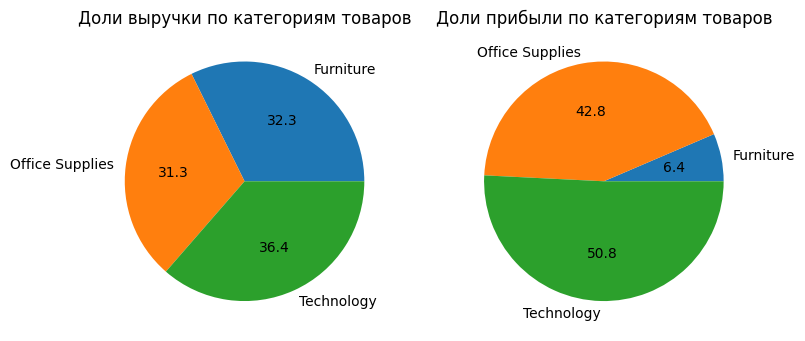

In [7]:
# считаем доли выручки по категориям товаров
categories = list(df['Category'].unique())
total_sales = df['Sales'].sum()
categories_sales = df[['Category', 'Sales']].groupby(by = 'Category').sum()/total_sales

# плотим то, что посчитали
fig, axs = plt.subplots(ncols = 2, nrows = 1, figsize = (8.5, 5.5))
axs[0].pie(
    x = list(categories_sales['Sales']),
    labels = categories,
    autopct='%.1f'
)
axs[0].set_title('Доли выручки по категориям товаров')

# считаем доли прибли по категориям товаров
total_profit = df['Profit'].sum()
categories_profit = df[['Category', 'Profit']].groupby(by = 'Category').sum()/total_profit

# плотим то, что посчитали
axs[1].pie(
    x = list(categories_profit['Profit']),
    labels = categories,
    autopct='%.1f'
)
axs[1].set_title('Доли прибыли по категориям товаров')

plt.show()

Как видим, доли выручки по категориям товаров примерно одинаковы, однако продажа мебели приносит меньше всего прибыли, поэтому, вероятно, фирме стоит сместить акцент на другие категории товаров или же как-то пересмотреть цены на продажу мебели (издержки от продажи мебели), для этого нужно больше данных.

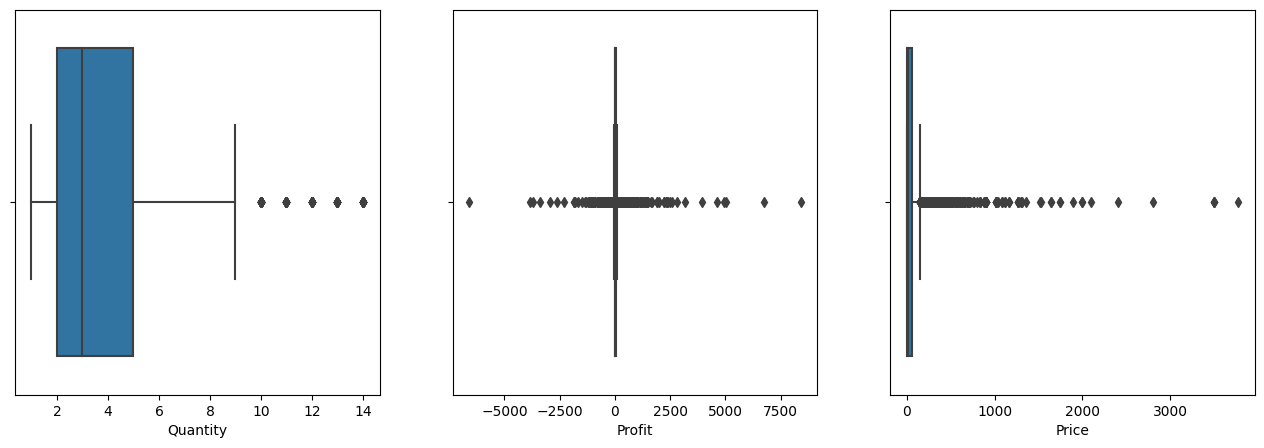

In [24]:
# Построим ящики с усами для колонок "количество", "прибыль", "цена"
fix, axs = plt.subplots(ncols = 3, nrows = 1, figsize = (16, 5))

sns.boxplot(
    x=df['Quantity'], 
    ax= axs[0]
)

sns.boxplot(
    x=df['Profit'], 
    ax= axs[1]
)

sns.boxplot(
    x=df['Price'], 
    ax= axs[2]
)

plt.show()

Видим, что прибыль от некоторых заказов была отрицательна. Посмотрим подробнее на такие заказы, в частности, на подкатегории товаров.

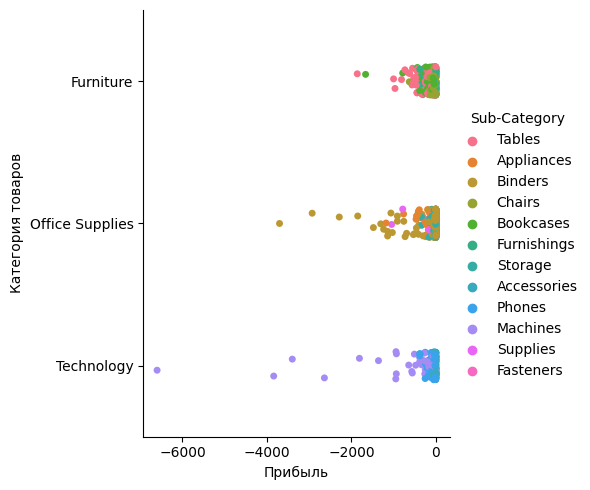

In [32]:
df_neg_profit = df[df['Profit'] < 0]

cat_plot = sns.catplot(
    data = df_neg_profit, 
    x = 'Profit', 
    y = 'Category', 
    hue = 'Sub-Category', 
)
plt.ylabel('Категория товаров')
plt.xlabel('Прибыль')

plt.show()

Как видим, на большинство заказов прибыль если и отрицательна, то в районе нуля. Стоит подробнее рассмотреть такие заказы и выяснить причину отрицательной прибыли, но для этого нужно больше данных.

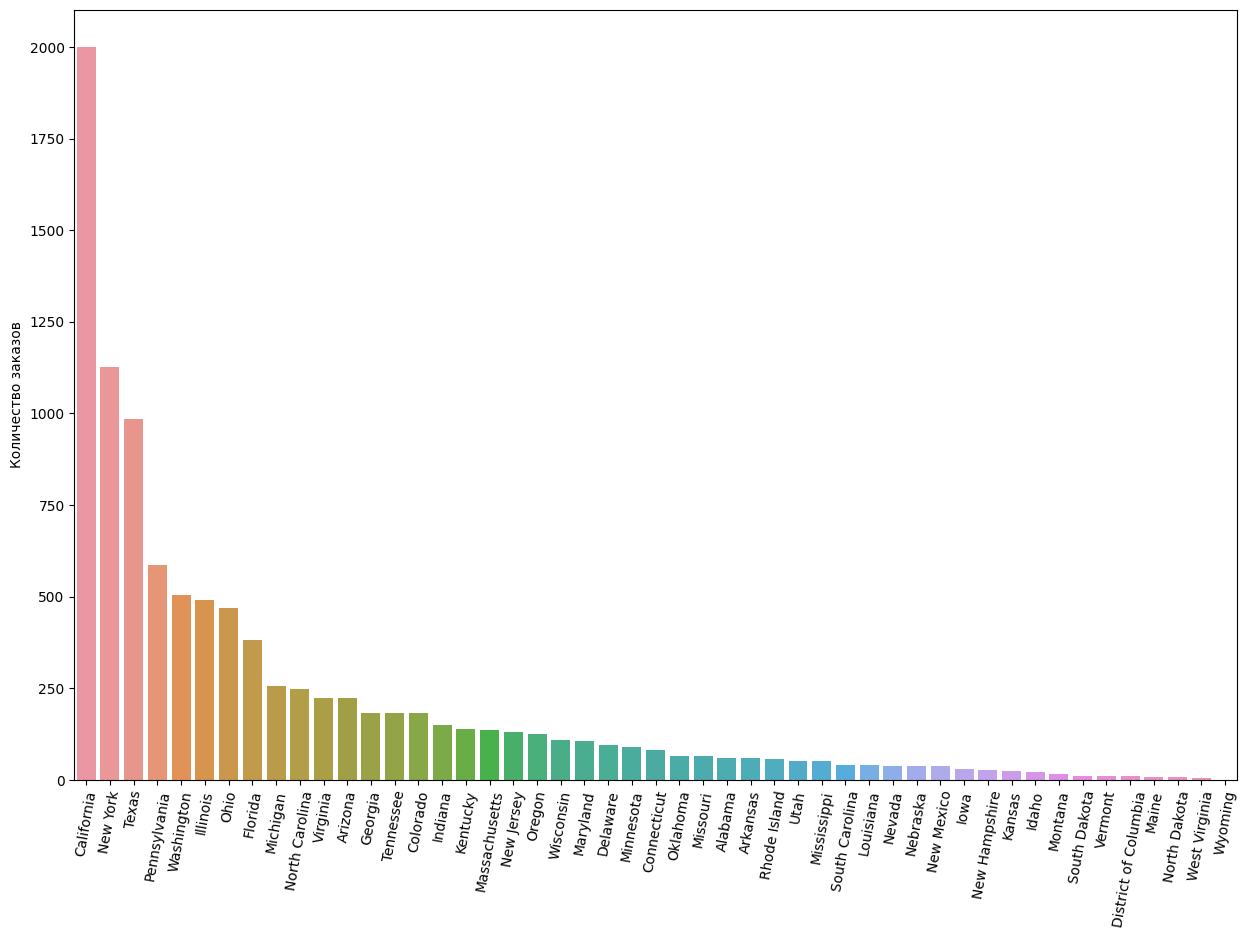

In [8]:
# Плотим распределение заказов по штатам
fig, ax = plt.subplots(figsize = (15, 10))
df_count_cats = df.groupby(by='State').count().sort_values(by = 'Row ID', ascending = False)
barplot_number_sales = sns.barplot(y= df_count_cats['Row ID'], x= df_count_cats.index.to_list())
barplot_number_sales.set_xticklabels(df_count_cats.index.to_list(), rotation=80)
ax.set_ylabel('Количество заказов')
plt.show()

Как видим, больше всего заказов приходятся на Калифорнию, Нью-Йорк, Техас. Также (ниже будет карта) на эти штаты приходится большая часть выручки. Отсюда следует, что магазину, вероятно, стоит построить склады ближе к этим штатам (или в них самих), тем более расстояние между штатами большое и данные склады могли бы обслуживать штаты по-соседству. 

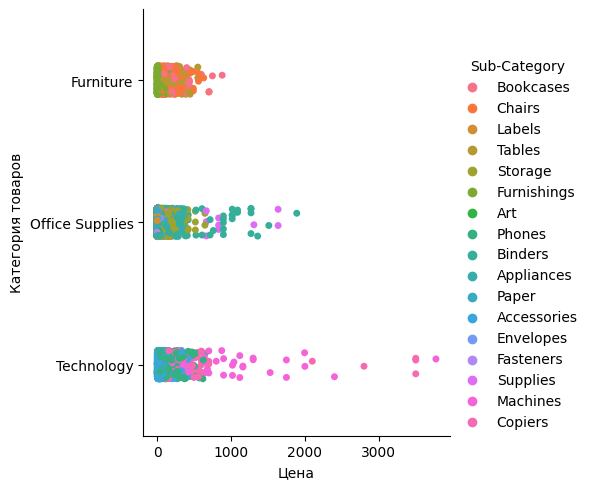

In [9]:
# Плотим распределение цен по категориям и подгатегориям. Видим, что на большинство товаров цены в диапазоне от 0 до 1000.
cat_plot = sns.catplot(
    data = df, 
    x = 'Price', 
    y = 'Category', 
    hue = 'Sub-Category', 
)
plt.ylabel('Категория товаров')
plt.xlabel('Цена')

plt.show()

Из графика видно, что самые дорогие товары принадлежат к категории "Технологии". Заплотим тот же график, только для диапазона цен от 0 до 500, чтобы лучше рассмотреть цены на подкатегории товаров, которые скучились вначалее графика.

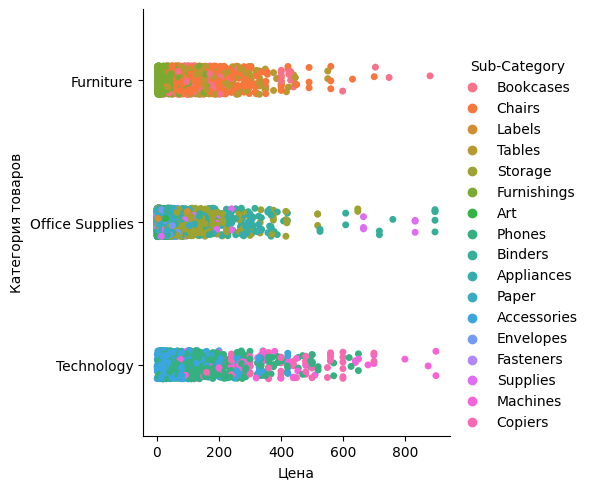

In [10]:
## Плотим цены до 1000, чтобы посмотреть подробнее цены на более дешевые товары. 
cat_plot = sns.catplot(
    data = df[df['Price'] <= 1000], 
    x = 'Price', 
    y = 'Category', 
    hue = 'Sub-Category'
)
plt.xlabel('Цена')
plt.ylabel('Категория товаров')
plt.show()

Видим, что на большинство товаров в категориях "Мебель" и "Офисные принадлежности" цены лежат в диапазоне от 0 до 400. У категории "Технологии" почти все цены в диапазоне от 0 до 500.

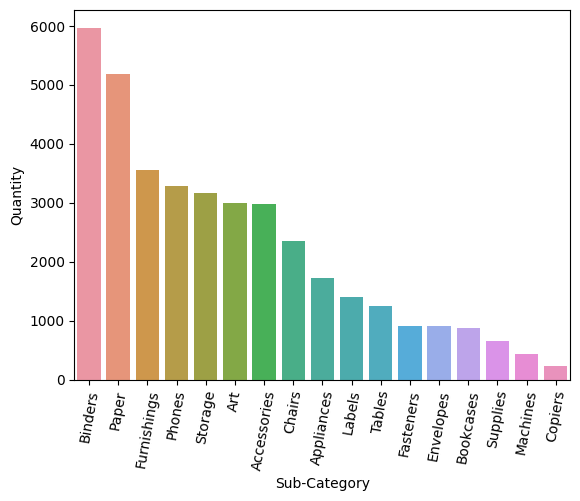

In [11]:
# Группировка продаж для каждой подкатегории товаров
df_subcat_quantity = df[['Sub-Category', 'Quantity']].groupby(by='Sub-Category').sum()
df_subcat_quantity.sort_values(
    by='Quantity', 
    inplace = True, 
    ascending = False
)

# Плотим то, что сгруппировали
plot = sns.barplot(
    data=df_subcat_quantity, 
    x=df_subcat_quantity.index, 
    y="Quantity"
)

plot.set_xticklabels(df_subcat_quantity.index.to_list(), rotation=80)
plt.show()

Видим, что больше всего спроса приходится на бумагу, скрепки (по сути небольшие офисные принадлежности)

### Плотим геоданные, распределение выручки по штатам.

Посмотрим выручку по штатам, чтобы примерно оценить спрос на продукцию магазина

In [12]:
usa = gpd.read_file(r'C:\Users\kiril\Downloads\us_state_coords\cb_2018_us_state_500k.shp')
# Карту США загружал с Американского правительственного сайта census.gov (без впн не заходит)

In [13]:
usa = usa.to_crs("EPSG:4326")  # Фиксируем систему координат, чтобы точки на карте и карта были в одной системе.

In [14]:
geo_coords = gpd.GeoDataFrame(coords, geometry=gpd.points_from_xy(-1 * coords.longitude, coords.latitude), crs = 'EPSG:4326')
# Приводим координаты точек штатов к типу GeoDataFrame

In [15]:
# Добавляем в датафрейм geo_coords суммарную выручку по штатам. 
sales_by_state = df[['State', 'Sales']].groupby(by = 'State').sum()/200
geo_coords.sort_values(by = 'state', inplace = True)
sales_by_state.sort_values(by='State', inplace = True)

geo_coords.insert(
    loc = 4, 
    column = 'sales', 
    value = sales_by_state['Sales'].to_list()
)

In [16]:
# избавляемся от штатов (ха!), которых нет в исходном датасете.
given_states = df['State'].unique()
for i in usa['NAME']:
    if i not in given_states:
        index = usa[usa['NAME'] == i].index[0]
        usa.drop(labels = [index], axis = 0, inplace = True)
len(usa['NAME']) == len(df['State'].unique())

True

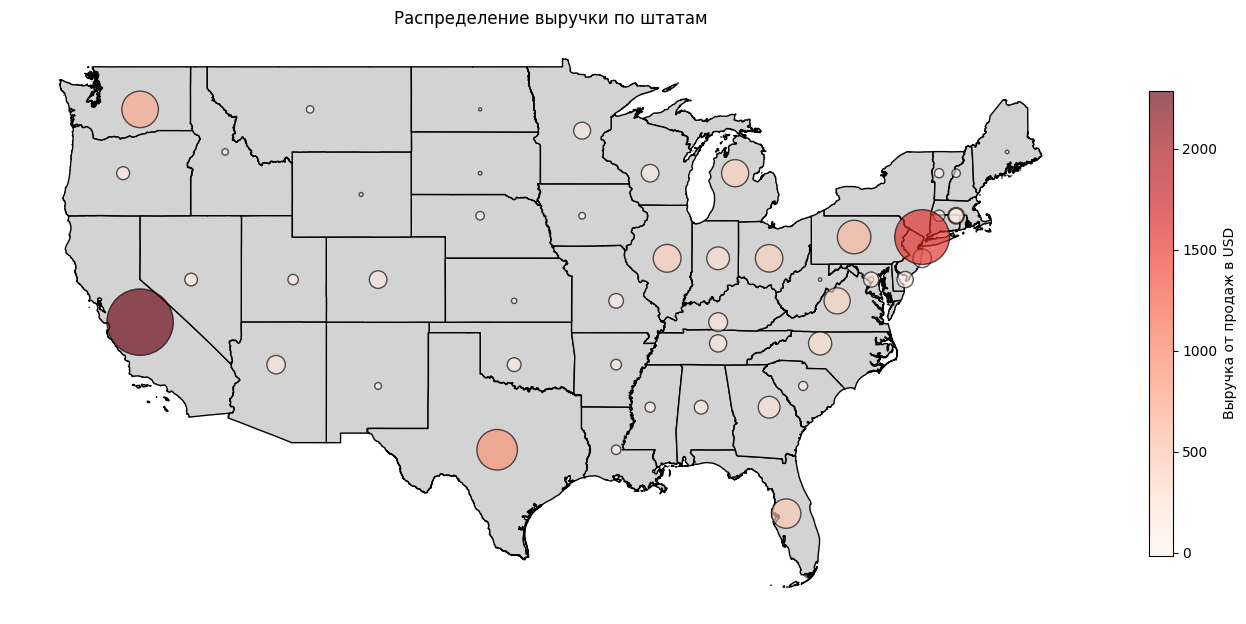

In [17]:
# определяем верхнюю и нижнюю границы для colormap
vmin = min(geo_coords['sales']) 
vmax = max(geo_coords['sales'])
# Записываем координаты точек, отображающих штаты.
x = -1*coords['longitude']
y = coords['latitude']
values = geo_coords['sales'].to_list()

# плотим карту Америки
fig, ax = plt.subplots(figsize=(15,15))

usa.plot(
    ax=ax, 
    edgecolor='black', 
    color="lightgrey", 
    linewidth=1
)

plt.scatter(
    x=x, 
    y=y,
    s=values, 
    c=values, 
    cmap='Reds', 
    vmin=vmin-20, 
    vmax=vmax, 
    alpha = 0.65, 
    edgecolor ='black'
)

plt.title("Распределение выручки по штатам")
plt.colorbar(label = "Выручка от продаж в USD", fraction=0.02, pad=0.05)
plt.axis('off')
plt.show()

Видим что больше всего выручки приходится на Нью-Йорк, Техас, Вашингтон, Калифорнию. Возможно, стоит поставить в этих штатах дополнительные склады или пункты выдачи заказов.

## Блок с машинным обучением. Попробуем предсказывать выручку и прибыль магазина по некоторым фичам из таблицы.

Потом посмотрим на фича импортанс и поймем от чего данные финансовые показатели зависят больше всего. Это может быть полезно, чтобы понять, имеет ли смысл фирме рассматривать больше работу с конкретным типом клиентов, заказов и пр.

In [42]:
df_boosting = df[['Ship Mode', 'Segment', 'State', 'Category', 'Sub-Category', 'Discount']]
target_sales = df['Sales']
target_profit = df['Profit']

In [19]:
df_boosting

,Ship Mode,Segment,State,Category,Sub-Category,Discount
0,Second Class,Consumer,Kentucky,Furniture,Bookcases,0.00
1,Second Class,Consumer,Kentucky,Furniture,Chairs,0.00
2,Second Class,Corporate,California,Office Supplies,Labels,0.00
3,Standard Class,Consumer,Florida,Furniture,Tables,0.45
4,Standard Class,Consumer,Florida,Office Supplies,Storage,0.20
...,...,...,...,...,...,...
9989,Second Class,Consumer,Florida,Furniture,Furnishings,0.20
9990,Standard Class,Consumer,California,Furniture,Furnishings,0.00
9991,Standard Class,Consumer,California,Technology,Phones,0.20
9992,Standard Class,Consumer,California,Office Supplies,Paper,0.00


In [43]:
# Закодируем LabelEncoder фичи, все кроме Discount категориальные
for feature in ['Ship Mode', 'Segment', 'State', 'Category', 'Sub-Category']:
    enc = LabelEncoder()
    df_boosting[feature] = enc.fit_transform(df[feature])

In [21]:
# Разобьем выборку на тренировочную, валидационную и тестовую.
X_train, X_test, y_train, y_test = train_test_split(df_boosting, target_sales, test_size = 0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25)

In [22]:
# Будем подбирать гиперпараметры для бустинга с помощью Оптуны. Метрику качества выберем MSE
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),  # ставим лог = тру чтобы лучше перебирать лернинг рейты
        'num_leaves': trial.suggest_int('num_leaves', 10, 120),
        'n_estimators': trial.suggest_int('n_estimators', 10, 100)
    }
    
    model = LGBMRegressor(**params)
    model.fit(
        X=X_train, 
        y=y_train
    )
    
    preds = model.predict(X_val)
    mse_valid = mean_squared_error(
        y_true=y_val, 
        y_pred=preds
    )
    
    return mse_valid

In [23]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=200)

[I 2024-06-09 00:46:25,389] A new study created in memory with name: no-name-0842d343-4623-4a67-a251-89d62aaefae3
[I 2024-06-09 00:46:25,718] Trial 0 finished with value: 244357.85816266993 and parameters: {'learning_rate': 0.0017100028320736712, 'num_leaves': 11, 'n_estimators': 13}. Best is trial 0 with value: 244357.85816266993.
[I 2024-06-09 00:46:25,904] Trial 1 finished with value: 224325.84094816464 and parameters: {'learning_rate': 0.041028197960822944, 'num_leaves': 85, 'n_estimators': 53}. Best is trial 1 with value: 224325.84094816464.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001239 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info

[I 2024-06-09 00:46:26,194] Trial 2 finished with value: 265859.9896752157 and parameters: {'learning_rate': 0.27840380738226345, 'num_leaves': 101, 'n_estimators': 76}. Best is trial 1 with value: 224325.84094816464.
[I 2024-06-09 00:46:26,274] Trial 3 finished with value: 236028.5076452324 and parameters: {'learning_rate': 0.1934756986618391, 'num_leaves': 48, 'n_estimators': 30}. Best is trial 1 with value: 224325.84094816464.
[I 2024-06-09 00:46:26,355] Trial 4 finished with value: 226829.06226328018 and parameters: {'learning_rate': 0.01431354870097198, 'num_leaves': 90, 'n_estimators': 19}. Best is trial 1 with value: 224325.84094816464.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000664 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info

[I 2024-06-09 00:46:26,422] Trial 5 finished with value: 218508.35950675534 and parameters: {'learning_rate': 0.010002349039501746, 'num_leaves': 18, 'n_estimators': 46}. Best is trial 5 with value: 218508.35950675534.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


[I 2024-06-09 00:46:26,764] Trial 6 finished with value: 221664.2633738531 and parameters: {'learning_rate': 0.019039412856891556, 'num_leaves': 117, 'n_estimators': 90}. Best is trial 5 with value: 218508.35950675534.
[I 2024-06-09 00:46:26,929] Trial 7 finished with value: 221438.26240979673 and parameters: {'learning_rate': 0.04306810278666051, 'num_leaves': 43, 'n_estimators': 66}. Best is trial 5 with value: 218508.35950675534.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


[I 2024-06-09 00:46:27,065] Trial 8 finished with value: 249481.44377467918 and parameters: {'learning_rate': 0.2762955586064109, 'num_leaves': 48, 'n_estimators': 46}. Best is trial 5 with value: 218508.35950675534.
[I 2024-06-09 00:46:27,212] Trial 9 finished with value: 226595.55696500032 and parameters: {'learning_rate': 0.004437777433152014, 'num_leaves': 33, 'n_estimators': 60}. Best is trial 5 with value: 218508.35950675534.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


[I 2024-06-09 00:46:27,369] Trial 10 finished with value: 230459.87835871844 and parameters: {'learning_rate': 0.005103886315554212, 'num_leaves': 10, 'n_estimators': 40}. Best is trial 5 with value: 218508.35950675534.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


[I 2024-06-09 00:46:27,641] Trial 11 finished with value: 223549.60035459435 and parameters: {'learning_rate': 0.07437904939581064, 'num_leaves': 33, 'n_estimators': 70}. Best is trial 5 with value: 218508.35950675534.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


[I 2024-06-09 00:46:27,978] Trial 12 finished with value: 222504.334176746 and parameters: {'learning_rate': 0.020381394355452824, 'num_leaves': 64, 'n_estimators': 97}. Best is trial 5 with value: 218508.35950675534.
[I 2024-06-09 00:46:28,192] Trial 13 finished with value: 218412.87099183942 and parameters: {'learning_rate': 0.0072328678293545855, 'num_leaves': 30, 'n_estimators': 66}. Best is trial 13 with value: 218412.87099183942.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000905 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


[I 2024-06-09 00:46:28,404] Trial 14 finished with value: 216781.12251372452 and parameters: {'learning_rate': 0.006554781957859765, 'num_leaves': 25, 'n_estimators': 81}. Best is trial 14 with value: 216781.12251372452.
[I 2024-06-09 00:46:28,646] Trial 15 finished with value: 237411.15863258808 and parameters: {'learning_rate': 0.001239061476946949, 'num_leaves': 65, 'n_estimators': 80}. Best is trial 14 with value: 216781.12251372452.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


[I 2024-06-09 00:46:28,839] Trial 16 finished with value: 225343.19166937555 and parameters: {'learning_rate': 0.003382967216218795, 'num_leaves': 24, 'n_estimators': 85}. Best is trial 14 with value: 216781.12251372452.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000722 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


[I 2024-06-09 00:46:29,070] Trial 17 finished with value: 212819.15098361913 and parameters: {'learning_rate': 0.008345135780547831, 'num_leaves': 32, 'n_estimators': 100}. Best is trial 17 with value: 212819.15098361913.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000886 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


[I 2024-06-09 00:46:29,397] Trial 18 finished with value: 227678.69209529454 and parameters: {'learning_rate': 0.0024999395957207974, 'num_leaves': 56, 'n_estimators': 100}. Best is trial 17 with value: 212819.15098361913.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000899 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


[I 2024-06-09 00:46:29,696] Trial 19 finished with value: 213997.82980202822 and parameters: {'learning_rate': 0.008516112150781558, 'num_leaves': 42, 'n_estimators': 93}. Best is trial 17 with value: 212819.15098361913.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000853 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


[I 2024-06-09 00:46:30,049] Trial 20 finished with value: 216340.54948467892 and parameters: {'learning_rate': 0.01224650274989106, 'num_leaves': 78, 'n_estimators': 92}. Best is trial 17 with value: 212819.15098361913.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


[I 2024-06-09 00:46:30,402] Trial 21 finished with value: 216005.2464184061 and parameters: {'learning_rate': 0.011559371312255913, 'num_leaves': 76, 'n_estimators': 92}. Best is trial 17 with value: 212819.15098361913.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


[I 2024-06-09 00:46:30,713] Trial 22 finished with value: 226728.42121325518 and parameters: {'learning_rate': 0.03250810855160592, 'num_leaves': 72, 'n_estimators': 90}. Best is trial 17 with value: 212819.15098361913.
[I 2024-06-09 00:46:30,943] Trial 23 finished with value: 213444.52999695757 and parameters: {'learning_rate': 0.008678815399754567, 'num_leaves': 41, 'n_estimators': 100}. Best is trial 17 with value: 212819.15098361913.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


[I 2024-06-09 00:46:31,224] Trial 24 finished with value: 226769.68450802317 and parameters: {'learning_rate': 0.002625996509074675, 'num_leaves': 40, 'n_estimators': 100}. Best is trial 17 with value: 212819.15098361913.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000903 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


[I 2024-06-09 00:46:31,481] Trial 25 finished with value: 216142.69762707388 and parameters: {'learning_rate': 0.007886660691923609, 'num_leaves': 56, 'n_estimators': 85}. Best is trial 17 with value: 212819.15098361913.
[I 2024-06-09 00:46:31,722] Trial 26 finished with value: 216931.09760871078 and parameters: {'learning_rate': 0.019525860641948594, 'num_leaves': 38, 'n_estimators': 95}. Best is trial 17 with value: 212819.15098361913.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000913 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


[I 2024-06-09 00:46:31,938] Trial 27 finished with value: 225005.91290371414 and parameters: {'learning_rate': 0.004149495098431973, 'num_leaves': 54, 'n_estimators': 74}. Best is trial 17 with value: 212819.15098361913.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


[I 2024-06-09 00:46:32,120] Trial 28 finished with value: 223737.27794143205 and parameters: {'learning_rate': 0.07068720771288203, 'num_leaves': 24, 'n_estimators': 88}. Best is trial 17 with value: 212819.15098361913.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


[I 2024-06-09 00:46:32,285] Trial 29 finished with value: 230844.08908332724 and parameters: {'learning_rate': 0.0018781622036140974, 'num_leaves': 17, 'n_estimators': 100}. Best is trial 17 with value: 212819.15098361913.
[I 2024-06-09 00:46:32,392] Trial 30 finished with value: 245145.44755808782 and parameters: {'learning_rate': 0.0010160557350299996, 'num_leaves': 47, 'n_estimators': 13}. Best is trial 17 with value: 212819.15098361913.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000972 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


[I 2024-06-09 00:46:32,744] Trial 31 finished with value: 215831.09737015865 and parameters: {'learning_rate': 0.011134203949561139, 'num_leaves': 73, 'n_estimators': 94}. Best is trial 17 with value: 212819.15098361913.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


[I 2024-06-09 00:46:33,131] Trial 32 finished with value: 223612.8659366932 and parameters: {'learning_rate': 0.028283258515396932, 'num_leaves': 61, 'n_estimators': 94}. Best is trial 17 with value: 212819.15098361913.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


[I 2024-06-09 00:46:33,455] Trial 33 finished with value: 216946.17593040422 and parameters: {'learning_rate': 0.009150575764056689, 'num_leaves': 95, 'n_estimators': 81}. Best is trial 17 with value: 212819.15098361913.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


[I 2024-06-09 00:46:33,747] Trial 34 finished with value: 219719.31987381674 and parameters: {'learning_rate': 0.005677685439038719, 'num_leaves': 70, 'n_estimators': 85}. Best is trial 17 with value: 212819.15098361913.
[I 2024-06-09 00:46:33,931] Trial 35 finished with value: 212645.74038283958 and parameters: {'learning_rate': 0.013901175762878503, 'num_leaves': 36, 'n_estimators': 76}. Best is trial 35 with value: 212645.74038283958.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


[I 2024-06-09 00:46:34,074] Trial 36 finished with value: 210606.2880741227 and parameters: {'learning_rate': 0.01487631171590991, 'num_leaves': 17, 'n_estimators': 76}. Best is trial 36 with value: 210606.2880741227.
[I 2024-06-09 00:46:34,204] Trial 37 finished with value: 212084.44675076293 and parameters: {'learning_rate': 0.0140218662266773, 'num_leaves': 18, 'n_estimators': 57}. Best is trial 36 with value: 210606.2880741227.
[I 2024-06-09 00:46:34,323] Trial 38 finished with value: 211447.28602730078 and parameters: {'learning_rate': 0.01548897752125529, 'num_leaves': 16, 'n_estimators': 56}. Best is trial 36 with value: 210606.2880741227.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


[I 2024-06-09 00:46:34,459] Trial 39 finished with value: 211497.68301470374 and parameters: {'learning_rate': 0.015420116912249858, 'num_leaves': 14, 'n_estimators': 56}. Best is trial 36 with value: 210606.2880741227.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000959 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


[I 2024-06-09 00:46:34,615] Trial 40 finished with value: 213525.0100856455 and parameters: {'learning_rate': 0.05987400742655243, 'num_leaves': 15, 'n_estimators': 57}. Best is trial 36 with value: 210606.2880741227.
[I 2024-06-09 00:46:34,776] Trial 41 finished with value: 211851.94589348146 and parameters: {'learning_rate': 0.015915981345147878, 'num_leaves': 19, 'n_estimators': 51}. Best is trial 36 with value: 210606.2880741227.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000895 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


[I 2024-06-09 00:46:34,910] Trial 42 finished with value: 211107.76492645618 and parameters: {'learning_rate': 0.024941543145296743, 'num_leaves': 13, 'n_estimators': 48}. Best is trial 36 with value: 210606.2880741227.
[I 2024-06-09 00:46:35,014] Trial 43 finished with value: 212989.14204335128 and parameters: {'learning_rate': 0.024959576024851694, 'num_leaves': 10, 'n_estimators': 47}. Best is trial 36 with value: 210606.2880741227.
[I 2024-06-09 00:46:35,133] Trial 44 finished with value: 212202.2551248696 and parameters: {'learning_rate': 0.0408218808914856, 'num_leaves': 22, 'n_estimators': 38}. Best is trial 36 with value: 210606.2880741227.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000924 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


[I 2024-06-09 00:46:35,249] Trial 45 finished with value: 211573.6830472966 and parameters: {'learning_rate': 0.01677347620252496, 'num_leaves': 14, 'n_estimators': 51}. Best is trial 36 with value: 210606.2880741227.
[I 2024-06-09 00:46:35,348] Trial 46 finished with value: 214492.86605426492 and parameters: {'learning_rate': 0.11996699941587555, 'num_leaves': 14, 'n_estimators': 31}. Best is trial 36 with value: 210606.2880741227.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000879 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


[I 2024-06-09 00:46:35,505] Trial 47 finished with value: 212177.83125185256 and parameters: {'learning_rate': 0.020396253021557405, 'num_leaves': 28, 'n_estimators': 63}. Best is trial 36 with value: 210606.2880741227.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


[I 2024-06-09 00:46:35,617] Trial 48 finished with value: 211354.40983106644 and parameters: {'learning_rate': 0.03503149284662753, 'num_leaves': 20, 'n_estimators': 40}. Best is trial 36 with value: 210606.2880741227.
[I 2024-06-09 00:46:35,795] Trial 49 finished with value: 221441.5297796829 and parameters: {'learning_rate': 0.044627117379371375, 'num_leaves': 107, 'n_estimators': 37}. Best is trial 36 with value: 210606.2880741227.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000728 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


[I 2024-06-09 00:46:35,946] Trial 50 finished with value: 213294.65989676706 and parameters: {'learning_rate': 0.0355779994740275, 'num_leaves': 28, 'n_estimators': 43}. Best is trial 36 with value: 210606.2880741227.
[I 2024-06-09 00:46:36,075] Trial 51 finished with value: 211083.12902847608 and parameters: {'learning_rate': 0.023931213163574713, 'num_leaves': 13, 'n_estimators': 52}. Best is trial 36 with value: 210606.2880741227.
[I 2024-06-09 00:46:36,192] Trial 52 finished with value: 211375.99157309777 and parameters: {'learning_rate': 0.02613625003576873, 'num_leaves': 21, 'n_estimators': 33}. Best is trial 36 with value: 210606.2880741227.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001012 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000916 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


[I 2024-06-09 00:46:36,299] Trial 53 finished with value: 212289.1330826598 and parameters: {'learning_rate': 0.024972303700644315, 'num_leaves': 22, 'n_estimators': 31}. Best is trial 36 with value: 210606.2880741227.
[I 2024-06-09 00:46:36,384] Trial 54 finished with value: 211227.11957374704 and parameters: {'learning_rate': 0.051557460226103864, 'num_leaves': 11, 'n_estimators': 27}. Best is trial 36 with value: 210606.2880741227.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000899 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


[I 2024-06-09 00:46:36,517] Trial 55 finished with value: 210584.1043271139 and parameters: {'learning_rate': 0.11118939618929354, 'num_leaves': 11, 'n_estimators': 24}. Best is trial 55 with value: 210584.1043271139.
[I 2024-06-09 00:46:36,590] Trial 56 finished with value: 213362.255134587 and parameters: {'learning_rate': 0.10319673173996033, 'num_leaves': 12, 'n_estimators': 20}. Best is trial 55 with value: 210584.1043271139.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000191 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info

[I 2024-06-09 00:46:36,654] Trial 57 finished with value: 214687.67115618833 and parameters: {'learning_rate': 0.18967780351013716, 'num_leaves': 11, 'n_estimators': 17}. Best is trial 55 with value: 210584.1043271139.
[I 2024-06-09 00:46:36,734] Trial 58 finished with value: 211909.56871754408 and parameters: {'learning_rate': 0.04842449557504878, 'num_leaves': 27, 'n_estimators': 27}. Best is trial 55 with value: 210584.1043271139.
[I 2024-06-09 00:46:36,823] Trial 59 finished with value: 210074.88717958075 and parameters: {'learning_rate': 0.10863141384918605, 'num_leaves': 10, 'n_estimators': 25}. Best is trial 59 with value: 210074.88717958075.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000888 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


[I 2024-06-09 00:46:36,935] Trial 60 finished with value: 211616.07620469065 and parameters: {'learning_rate': 0.10686019459640841, 'num_leaves': 10, 'n_estimators': 21}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:37,069] Trial 61 finished with value: 214195.09458861468 and parameters: {'learning_rate': 0.0840511286764347, 'num_leaves': 19, 'n_estimators': 26}. Best is trial 59 with value: 210074.88717958075.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000187 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


[I 2024-06-09 00:46:37,194] Trial 62 finished with value: 220005.2728518765 and parameters: {'learning_rate': 0.15732582311167145, 'num_leaves': 34, 'n_estimators': 25}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:37,281] Trial 63 finished with value: 217174.53915791537 and parameters: {'learning_rate': 0.05044714462115421, 'num_leaves': 24, 'n_estimators': 10}. Best is trial 59 with value: 210074.88717958075.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testin

[I 2024-06-09 00:46:37,402] Trial 64 finished with value: 213461.94482554347 and parameters: {'learning_rate': 0.061073827425547005, 'num_leaves': 19, 'n_estimators': 42}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:37,505] Trial 65 finished with value: 214989.26937092876 and parameters: {'learning_rate': 0.14845306663593755, 'num_leaves': 10, 'n_estimators': 47}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:37,600] Trial 66 finished with value: 210620.26666001033 and parameters: {'learning_rate': 0.03228974894693327, 'num_leaves': 15, 'n_estimators': 35}. Best is trial 59 with value: 210074.88717958075.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000831 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testin

[I 2024-06-09 00:46:37,701] Trial 67 finished with value: 229054.77809325114 and parameters: {'learning_rate': 0.2278644730938778, 'num_leaves': 15, 'n_estimators': 36}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:37,796] Trial 68 finished with value: 214185.8221839812 and parameters: {'learning_rate': 0.08270979333761438, 'num_leaves': 25, 'n_estimators': 23}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:37,885] Trial 69 finished with value: 223608.31364698324 and parameters: {'learning_rate': 0.020507066374118407, 'num_leaves': 31, 'n_estimators': 16}. Best is trial 59 with value: 210074.88717958075.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000721 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000884 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testin

[I 2024-06-09 00:46:37,973] Trial 70 finished with value: 210800.6665728584 and parameters: {'learning_rate': 0.02964659277337767, 'num_leaves': 14, 'n_estimators': 34}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:38,058] Trial 71 finished with value: 211208.1433193412 and parameters: {'learning_rate': 0.03310504765794241, 'num_leaves': 13, 'n_estimators': 29}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:38,178] Trial 72 finished with value: 211800.62946224745 and parameters: {'learning_rate': 0.023705323356100844, 'num_leaves': 16, 'n_estimators': 34}. Best is trial 59 with value: 210074.88717958075.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000833 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000322 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


[I 2024-06-09 00:46:38,267] Trial 73 finished with value: 211868.29456492004 and parameters: {'learning_rate': 0.028925269514266907, 'num_leaves': 13, 'n_estimators': 29}. Best is trial 59 with value: 210074.88717958075.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


[I 2024-06-09 00:46:38,449] Trial 74 finished with value: 213850.3386210366 and parameters: {'learning_rate': 0.03992865794857878, 'num_leaves': 17, 'n_estimators': 70}. Best is trial 59 with value: 210074.88717958075.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


[I 2024-06-09 00:46:39,113] Trial 75 finished with value: 224098.47992383025 and parameters: {'learning_rate': 0.29977120084317493, 'num_leaves': 22, 'n_estimators': 23}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:39,227] Trial 76 finished with value: 216060.0192178743 and parameters: {'learning_rate': 0.02915645528159776, 'num_leaves': 83, 'n_estimators': 34}. Best is trial 59 with value: 210074.88717958075.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


[I 2024-06-09 00:46:39,513] Trial 77 finished with value: 211407.11600084623 and parameters: {'learning_rate': 0.021933115388938964, 'num_leaves': 13, 'n_estimators': 62}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:39,621] Trial 78 finished with value: 213899.9069796003 and parameters: {'learning_rate': 0.03363952509344946, 'num_leaves': 27, 'n_estimators': 50}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:39,710] Trial 79 finished with value: 212332.98886981857 and parameters: {'learning_rate': 0.01815507037181161, 'num_leaves': 17, 'n_estimators': 42}. Best is trial 59 with value: 210074.88717958075.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000744 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000757 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testin

[I 2024-06-09 00:46:39,790] Trial 80 finished with value: 221511.9040808735 and parameters: {'learning_rate': 0.01279174965316237, 'num_leaves': 22, 'n_estimators': 29}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:39,844] Trial 81 finished with value: 212585.4977389112 and parameters: {'learning_rate': 0.05517176349339559, 'num_leaves': 10, 'n_estimators': 23}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:39,906] Trial 82 finished with value: 211628.17192968336 and parameters: {'learning_rate': 0.0667148537660722, 'num_leaves': 12, 'n_estimators': 27}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:39,976] Trial 83 finished with value: 211352.2490500477 and parameters: {'learning_rate': 0.03112363158606613, 'num_leaves': 16, 'n_estimators': 54}. Best is trial 59 with value: 210074.88717958075.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testin

[I 2024-06-09 00:46:40,089] Trial 84 finished with value: 211447.52945851797 and parameters: {'learning_rate': 0.08083584299659652, 'num_leaves': 13, 'n_estimators': 17}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:40,222] Trial 85 finished with value: 211511.52592873905 and parameters: {'learning_rate': 0.03740638077515171, 'num_leaves': 19, 'n_estimators': 44}. Best is trial 59 with value: 210074.88717958075.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000815 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000901 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


[I 2024-06-09 00:46:40,367] Trial 86 finished with value: 220515.89193467196 and parameters: {'learning_rate': 0.010294338021869258, 'num_leaves': 24, 'n_estimators': 39}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:40,467] Trial 87 finished with value: 219725.1252888828 and parameters: {'learning_rate': 0.04753151114831355, 'num_leaves': 120, 'n_estimators': 31}. Best is trial 59 with value: 210074.88717958075.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info

[I 2024-06-09 00:46:40,551] Trial 88 finished with value: 214276.91597004098 and parameters: {'learning_rate': 0.13100946915589026, 'num_leaves': 15, 'n_estimators': 25}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:40,644] Trial 89 finished with value: 215375.63674828544 and parameters: {'learning_rate': 0.017953950933786742, 'num_leaves': 10, 'n_estimators': 36}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:40,748] Trial 90 finished with value: 211130.65244824454 and parameters: {'learning_rate': 0.0413162332066681, 'num_leaves': 18, 'n_estimators': 33}. Best is trial 59 with value: 210074.88717958075.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


[I 2024-06-09 00:46:40,857] Trial 91 finished with value: 212607.20327918045 and parameters: {'learning_rate': 0.022350639015816413, 'num_leaves': 19, 'n_estimators': 33}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:40,951] Trial 92 finished with value: 211793.23823256252 and parameters: {'learning_rate': 0.0924010718907285, 'num_leaves': 13, 'n_estimators': 29}. Best is trial 59 with value: 210074.88717958075.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000936 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testin

[I 2024-06-09 00:46:41,041] Trial 93 finished with value: 211073.7095918154 and parameters: {'learning_rate': 0.04121839863831112, 'num_leaves': 17, 'n_estimators': 22}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:41,143] Trial 94 finished with value: 217367.468089219 and parameters: {'learning_rate': 0.026444675788296988, 'num_leaves': 45, 'n_estimators': 21}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:41,233] Trial 95 finished with value: 217381.18455472137 and parameters: {'learning_rate': 0.039268201654803464, 'num_leaves': 29, 'n_estimators': 13}. Best is trial 59 with value: 210074.88717958075.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000659 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000905 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


[I 2024-06-09 00:46:41,427] Trial 96 finished with value: 220371.1558608637 and parameters: {'learning_rate': 0.03285756236561842, 'num_leaves': 51, 'n_estimators': 59}. Best is trial 59 with value: 210074.88717958075.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


[I 2024-06-09 00:46:41,571] Trial 97 finished with value: 212569.6592134427 and parameters: {'learning_rate': 0.04318537955109516, 'num_leaves': 17, 'n_estimators': 49}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:41,639] Trial 98 finished with value: 210784.1400428077 and parameters: {'learning_rate': 0.05907519141100979, 'num_leaves': 20, 'n_estimators': 18}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:41,695] Trial 99 finished with value: 210670.63622705385 and parameters: {'learning_rate': 0.06057311227339596, 'num_leaves': 21, 'n_estimators': 18}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:41,749] Trial 100 finished with value: 210834.20010548364 and parameters: {'learning_rate': 0.06300738799335374, 'num_leaves': 21, 'n_estimators': 15}. Best is trial 59 with value: 210074.88717958075.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testin

[I 2024-06-09 00:46:41,861] Trial 101 finished with value: 211210.38865093907 and parameters: {'learning_rate': 0.06879285384078028, 'num_leaves': 25, 'n_estimators': 15}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:41,991] Trial 102 finished with value: 210963.168991109 and parameters: {'learning_rate': 0.11618097740350815, 'num_leaves': 21, 'n_estimators': 11}. Best is trial 59 with value: 210074.88717958075.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000825 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


[I 2024-06-09 00:46:42,067] Trial 103 finished with value: 210695.56523822146 and parameters: {'learning_rate': 0.10794958960662145, 'num_leaves': 21, 'n_estimators': 10}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:42,170] Trial 104 finished with value: 217437.84221274586 and parameters: {'learning_rate': 0.10196890308702186, 'num_leaves': 34, 'n_estimators': 19}. Best is trial 59 with value: 210074.88717958075.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found white

[I 2024-06-09 00:46:42,255] Trial 105 finished with value: 210547.00820623233 and parameters: {'learning_rate': 0.11518694456814273, 'num_leaves': 21, 'n_estimators': 10}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:42,348] Trial 106 finished with value: 211145.245428433 and parameters: {'learning_rate': 0.1274598685418811, 'num_leaves': 21, 'n_estimators': 10}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:42,437] Trial 107 finished with value: 215691.65558242865 and parameters: {'learning_rate': 0.16015244182504218, 'num_leaves': 26, 'n_estimators': 12}. Best is trial 59 with value: 210074.88717958075.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000918 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testin

[I 2024-06-09 00:46:42,541] Trial 108 finished with value: 216461.11645496212 and parameters: {'learning_rate': 0.19137321002647667, 'num_leaves': 30, 'n_estimators': 15}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:42,642] Trial 109 finished with value: 210989.79686416243 and parameters: {'learning_rate': 0.09373938992698534, 'num_leaves': 22, 'n_estimators': 12}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:42,758] Trial 110 finished with value: 214575.85148502034 and parameters: {'learning_rate': 0.11059078737655184, 'num_leaves': 23, 'n_estimators': 18}. Best is trial 59 with value: 210074.88717958075.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000696 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


[I 2024-06-09 00:46:42,858] Trial 111 finished with value: 211010.34345871597 and parameters: {'learning_rate': 0.076012081066621, 'num_leaves': 21, 'n_estimators': 12}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:42,979] Trial 112 finished with value: 216599.85471331808 and parameters: {'learning_rate': 0.11856231988571393, 'num_leaves': 36, 'n_estimators': 14}. Best is trial 59 with value: 210074.88717958075.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000817 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000891 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


[I 2024-06-09 00:46:43,091] Trial 113 finished with value: 210874.46449826745 and parameters: {'learning_rate': 0.09201588396623255, 'num_leaves': 20, 'n_estimators': 12}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:43,200] Trial 114 finished with value: 210765.7145777707 and parameters: {'learning_rate': 0.06160969037216165, 'num_leaves': 20, 'n_estimators': 19}. Best is trial 59 with value: 210074.88717958075.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000955 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testin

[I 2024-06-09 00:46:43,301] Trial 115 finished with value: 211652.25323712194 and parameters: {'learning_rate': 0.062158869228342434, 'num_leaves': 26, 'n_estimators': 19}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:43,414] Trial 116 finished with value: 214907.99002692438 and parameters: {'learning_rate': 0.09638888245081706, 'num_leaves': 32, 'n_estimators': 16}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:43,538] Trial 117 finished with value: 212448.59920721737 and parameters: {'learning_rate': 0.13443999019109237, 'num_leaves': 19, 'n_estimators': 14}. Best is trial 59 with value: 210074.88717958075.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000374 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


[I 2024-06-09 00:46:43,621] Trial 118 finished with value: 211199.8886735383 and parameters: {'learning_rate': 0.08613610717012721, 'num_leaves': 15, 'n_estimators': 18}. Best is trial 59 with value: 210074.88717958075.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


[I 2024-06-09 00:46:43,864] Trial 119 finished with value: 211102.8296161629 and parameters: {'learning_rate': 0.055719742601517554, 'num_leaves': 24, 'n_estimators': 21}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:43,952] Trial 120 finished with value: 212310.50061610385 and parameters: {'learning_rate': 0.0754745581625916, 'num_leaves': 28, 'n_estimators': 17}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:44,008] Trial 121 finished with value: 211258.86004625965 and parameters: {'learning_rate': 0.1703905408244249, 'num_leaves': 15, 'n_estimators': 10}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:44,082] Trial 122 finished with value: 211613.19754448984 and parameters: {'learning_rate': 0.1392361358615409, 'num_leaves': 20, 'n_estimators': 10}. Best is trial 59 with value: 210074.88717958075.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testin

[I 2024-06-09 00:46:44,153] Trial 123 finished with value: 214249.31742817414 and parameters: {'learning_rate': 0.23774078964902592, 'num_leaves': 17, 'n_estimators': 14}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:44,226] Trial 124 finished with value: 219095.43395341872 and parameters: {'learning_rate': 0.11210761445940301, 'num_leaves': 106, 'n_estimators': 12}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:44,298] Trial 125 finished with value: 211124.2421906126 and parameters: {'learning_rate': 0.06795429964795074, 'num_leaves': 20, 'n_estimators': 20}. Best is trial 59 with value: 210074.88717958075.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testin

[I 2024-06-09 00:46:44,365] Trial 126 finished with value: 214692.74991342906 and parameters: {'learning_rate': 0.08887144323342833, 'num_leaves': 23, 'n_estimators': 24}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:44,421] Trial 127 finished with value: 212238.16258867874 and parameters: {'learning_rate': 0.05620713605615673, 'num_leaves': 12, 'n_estimators': 15}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:44,513] Trial 128 finished with value: 211048.13935061518 and parameters: {'learning_rate': 0.0747891383093026, 'num_leaves': 15, 'n_estimators': 12}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:44,585] Trial 129 finished with value: 212038.45864271236 and parameters: {'learning_rate': 0.10293853060717867, 'num_leaves': 20, 'n_estimators': 17}. Best is trial 59 with value: 210074.88717958075.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testin

[I 2024-06-09 00:46:44,720] Trial 130 finished with value: 211822.65282721815 and parameters: {'learning_rate': 0.06522961864553635, 'num_leaves': 26, 'n_estimators': 19}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:44,816] Trial 131 finished with value: 211103.28872586417 and parameters: {'learning_rate': 0.09460431105079861, 'num_leaves': 21, 'n_estimators': 11}. Best is trial 59 with value: 210074.88717958075.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000843 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


[I 2024-06-09 00:46:44,980] Trial 132 finished with value: 213830.38922845357 and parameters: {'learning_rate': 0.12149861555483221, 'num_leaves': 22, 'n_estimators': 16}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:45,071] Trial 133 finished with value: 212029.88159874303 and parameters: {'learning_rate': 0.1466791785562629, 'num_leaves': 16, 'n_estimators': 13}. Best is trial 59 with value: 210074.88717958075.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


[I 2024-06-09 00:46:45,192] Trial 134 finished with value: 210665.52925832765 and parameters: {'learning_rate': 0.08276730152872815, 'num_leaves': 18, 'n_estimators': 14}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:45,293] Trial 135 finished with value: 211847.80520823487 and parameters: {'learning_rate': 0.07528722387879588, 'num_leaves': 18, 'n_estimators': 22}. Best is trial 59 with value: 210074.88717958075.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info

[I 2024-06-09 00:46:45,378] Trial 136 finished with value: 215940.59812032044 and parameters: {'learning_rate': 0.08561794518714891, 'num_leaves': 60, 'n_estimators': 14}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:45,484] Trial 137 finished with value: 213144.23650341257 and parameters: {'learning_rate': 0.1146547802514837, 'num_leaves': 10, 'n_estimators': 10}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:45,624] Trial 138 finished with value: 210814.60324165117 and parameters: {'learning_rate': 0.047611338553295586, 'num_leaves': 14, 'n_estimators': 25}. Best is trial 59 with value: 210074.88717958075.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000616 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


[I 2024-06-09 00:46:45,719] Trial 139 finished with value: 210907.84345570055 and parameters: {'learning_rate': 0.04831042293595701, 'num_leaves': 12, 'n_estimators': 26}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:45,839] Trial 140 finished with value: 211291.49493055922 and parameters: {'learning_rate': 0.058697560213613297, 'num_leaves': 14, 'n_estimators': 24}. Best is trial 59 with value: 210074.88717958075.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000831 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


[I 2024-06-09 00:46:45,962] Trial 141 finished with value: 210936.78783896894 and parameters: {'learning_rate': 0.047882061626022585, 'num_leaves': 12, 'n_estimators': 27}. Best is trial 59 with value: 210074.88717958075.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000603 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


[I 2024-06-09 00:46:46,123] Trial 142 finished with value: 210712.36414130803 and parameters: {'learning_rate': 0.046575547623737695, 'num_leaves': 18, 'n_estimators': 25}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:46,228] Trial 143 finished with value: 210778.43256968362 and parameters: {'learning_rate': 0.05275680607145041, 'num_leaves': 18, 'n_estimators': 20}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:46,340] Trial 144 finished with value: 210676.7848730423 and parameters: {'learning_rate': 0.061073690671984315, 'num_leaves': 17, 'n_estimators': 20}. Best is trial 59 with value: 210074.88717958075.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


[I 2024-06-09 00:46:46,470] Trial 145 finished with value: 210691.61364392954 and parameters: {'learning_rate': 0.05424221659795725, 'num_leaves': 16, 'n_estimators': 22}. Best is trial 59 with value: 210074.88717958075.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


[I 2024-06-09 00:46:46,613] Trial 146 finished with value: 210644.03432963887 and parameters: {'learning_rate': 0.05453387728507112, 'num_leaves': 17, 'n_estimators': 21}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:46,724] Trial 147 finished with value: 210561.32345536503 and parameters: {'learning_rate': 0.05319500158290352, 'num_leaves': 16, 'n_estimators': 21}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:46,851] Trial 148 finished with value: 210600.67558478197 and parameters: {'learning_rate': 0.05277338725685461, 'num_leaves': 17, 'n_estimators': 22}. Best is trial 59 with value: 210074.88717958075.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000993 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


[I 2024-06-09 00:46:47,006] Trial 149 finished with value: 210635.626927675 and parameters: {'learning_rate': 0.052070542477131845, 'num_leaves': 17, 'n_estimators': 23}. Best is trial 59 with value: 210074.88717958075.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000515 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


[I 2024-06-09 00:46:47,208] Trial 150 finished with value: 210647.2453888939 and parameters: {'learning_rate': 0.05248258917023682, 'num_leaves': 16, 'n_estimators': 22}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:47,304] Trial 151 finished with value: 210735.45531427415 and parameters: {'learning_rate': 0.05268183576488381, 'num_leaves': 17, 'n_estimators': 23}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:47,393] Trial 152 finished with value: 210846.97538353546 and parameters: {'learning_rate': 0.04521322378239369, 'num_leaves': 16, 'n_estimators': 28}. Best is trial 59 with value: 210074.88717958075.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testin

[I 2024-06-09 00:46:47,485] Trial 153 finished with value: 213607.61319100886 and parameters: {'learning_rate': 0.036403195406567015, 'num_leaves': 10, 'n_estimators': 22}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:47,592] Trial 154 finished with value: 212083.9491483798 and parameters: {'learning_rate': 0.07161727012144148, 'num_leaves': 17, 'n_estimators': 24}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:47,696] Trial 155 finished with value: 210737.60673265447 and parameters: {'learning_rate': 0.05449039888822468, 'num_leaves': 14, 'n_estimators': 21}. Best is trial 59 with value: 210074.88717958075.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


[I 2024-06-09 00:46:47,799] Trial 156 finished with value: 210825.11476946026 and parameters: {'learning_rate': 0.042731309987530136, 'num_leaves': 24, 'n_estimators': 26}. Best is trial 59 with value: 210074.88717958075.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


[I 2024-06-09 00:46:47,953] Trial 157 finished with value: 220037.04473811892 and parameters: {'learning_rate': 0.06902035287023256, 'num_leaves': 89, 'n_estimators': 22}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:48,078] Trial 158 finished with value: 211422.97724422254 and parameters: {'learning_rate': 0.06412224043196903, 'num_leaves': 12, 'n_estimators': 72}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:48,193] Trial 159 finished with value: 210889.95510011443 and parameters: {'learning_rate': 0.051232023197816216, 'num_leaves': 18, 'n_estimators': 20}. Best is trial 59 with value: 210074.88717958075.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000738 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


[I 2024-06-09 00:46:48,364] Trial 160 finished with value: 215310.2654894987 and parameters: {'learning_rate': 0.05844395406122279, 'num_leaves': 15, 'n_estimators': 76}. Best is trial 59 with value: 210074.88717958075.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


[I 2024-06-09 00:46:48,463] Trial 161 finished with value: 210773.88338653464 and parameters: {'learning_rate': 0.05140114794561684, 'num_leaves': 17, 'n_estimators': 24}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:48,612] Trial 162 finished with value: 210770.1866527661 and parameters: {'learning_rate': 0.04468634061132131, 'num_leaves': 18, 'n_estimators': 23}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:48,713] Trial 163 finished with value: 213115.19383131713 and parameters: {'learning_rate': 0.08245436542486738, 'num_leaves': 16, 'n_estimators': 26}. Best is trial 59 with value: 210074.88717958075.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


[I 2024-06-09 00:46:48,820] Trial 164 finished with value: 211192.3146412589 and parameters: {'learning_rate': 0.03622445378163272, 'num_leaves': 12, 'n_estimators': 31}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:48,898] Trial 165 finished with value: 225789.73061485402 and parameters: {'learning_rate': 0.013343304846561196, 'num_leaves': 10, 'n_estimators': 22}. Best is trial 59 with value: 210074.88717958075.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000677 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testin

[I 2024-06-09 00:46:48,980] Trial 166 finished with value: 213055.38605075836 and parameters: {'learning_rate': 0.040204181572744635, 'num_leaves': 23, 'n_estimators': 18}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:49,055] Trial 167 finished with value: 210806.9525057234 and parameters: {'learning_rate': 0.052483817584359625, 'num_leaves': 14, 'n_estimators': 20}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:49,140] Trial 168 finished with value: 213111.65154546613 and parameters: {'learning_rate': 0.07790624864575733, 'num_leaves': 18, 'n_estimators': 25}. Best is trial 59 with value: 210074.88717958075.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info

[I 2024-06-09 00:46:49,234] Trial 169 finished with value: 212026.78810761386 and parameters: {'learning_rate': 0.06736613719368606, 'num_leaves': 15, 'n_estimators': 28}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:49,370] Trial 170 finished with value: 214580.33780506902 and parameters: {'learning_rate': 0.057636531137411566, 'num_leaves': 19, 'n_estimators': 67}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:49,461] Trial 171 finished with value: 211007.74538936588 and parameters: {'learning_rate': 0.05387016410773856, 'num_leaves': 13, 'n_estimators': 21}. Best is trial 59 with value: 210074.88717958075.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


[I 2024-06-09 00:46:49,585] Trial 172 finished with value: 214841.00340048643 and parameters: {'learning_rate': 0.04677729842003324, 'num_leaves': 16, 'n_estimators': 80}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:49,662] Trial 173 finished with value: 210979.40732446633 and parameters: {'learning_rate': 0.0570434083148174, 'num_leaves': 14, 'n_estimators': 21}. Best is trial 59 with value: 210074.88717958075.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testin

[I 2024-06-09 00:46:49,743] Trial 174 finished with value: 210561.25485839654 and parameters: {'learning_rate': 0.06221042055283632, 'num_leaves': 12, 'n_estimators': 23}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:49,819] Trial 175 finished with value: 211277.91328584298 and parameters: {'learning_rate': 0.06638199660083136, 'num_leaves': 10, 'n_estimators': 24}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:49,914] Trial 176 finished with value: 212549.59772059525 and parameters: {'learning_rate': 0.10332235331261178, 'num_leaves': 17, 'n_estimators': 18}. Best is trial 59 with value: 210074.88717958075.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testin

[I 2024-06-09 00:46:49,992] Trial 177 finished with value: 213293.1978647473 and parameters: {'learning_rate': 0.07730581516991337, 'num_leaves': 23, 'n_estimators': 23}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:50,093] Trial 178 finished with value: 212128.61333866534 and parameters: {'learning_rate': 0.06383161282264777, 'num_leaves': 19, 'n_estimators': 27}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:50,168] Trial 179 finished with value: 213406.55880372127 and parameters: {'learning_rate': 0.0447478282585781, 'num_leaves': 12, 'n_estimators': 16}. Best is trial 59 with value: 210074.88717958075.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000834 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testin

[I 2024-06-09 00:46:50,253] Trial 180 finished with value: 212107.745407371 and parameters: {'learning_rate': 0.08375093058572601, 'num_leaves': 21, 'n_estimators': 19}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:50,361] Trial 181 finished with value: 210607.20942009048 and parameters: {'learning_rate': 0.05348770907520818, 'num_leaves': 15, 'n_estimators': 22}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:50,470] Trial 182 finished with value: 210590.54966234442 and parameters: {'learning_rate': 0.048652861656744366, 'num_leaves': 16, 'n_estimators': 23}. Best is trial 59 with value: 210074.88717958075.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000884 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000936 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


[I 2024-06-09 00:46:50,571] Trial 183 finished with value: 210735.4438354782 and parameters: {'learning_rate': 0.04093097677143257, 'num_leaves': 15, 'n_estimators': 25}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:50,677] Trial 184 finished with value: 211417.1488160507 and parameters: {'learning_rate': 0.05877587922321547, 'num_leaves': 12, 'n_estimators': 30}. Best is trial 59 with value: 210074.88717958075.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


[I 2024-06-09 00:46:50,781] Trial 185 finished with value: 211300.83963665858 and parameters: {'learning_rate': 0.049522107067517744, 'num_leaves': 19, 'n_estimators': 17}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:50,889] Trial 186 finished with value: 226965.26103704463 and parameters: {'learning_rate': 0.011605321562211716, 'num_leaves': 14, 'n_estimators': 22}. Best is trial 59 with value: 210074.88717958075.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000886 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


[I 2024-06-09 00:46:50,995] Trial 187 finished with value: 225522.54280342115 and parameters: {'learning_rate': 0.014730707365569938, 'num_leaves': 16, 'n_estimators': 19}. Best is trial 59 with value: 210074.88717958075.
[I 2024-06-09 00:46:51,090] Trial 188 finished with value: 209866.90806220417 and parameters: {'learning_rate': 0.07327150163831514, 'num_leaves': 10, 'n_estimators': 24}. Best is trial 188 with value: 209866.90806220417.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testin

[I 2024-06-09 00:46:51,186] Trial 189 finished with value: 211909.1034158379 and parameters: {'learning_rate': 0.0701748800994297, 'num_leaves': 10, 'n_estimators': 21}. Best is trial 188 with value: 209866.90806220417.
[I 2024-06-09 00:46:51,288] Trial 190 finished with value: 211223.30037974362 and parameters: {'learning_rate': 0.09487604572054396, 'num_leaves': 12, 'n_estimators': 23}. Best is trial 188 with value: 209866.90806220417.
[I 2024-06-09 00:46:51,398] Trial 191 finished with value: 211310.5684661747 and parameters: {'learning_rate': 0.06122774066205435, 'num_leaves': 16, 'n_estimators': 25}. Best is trial 188 with value: 209866.90806220417.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000886 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testin

[I 2024-06-09 00:46:51,502] Trial 192 finished with value: 211113.54286271473 and parameters: {'learning_rate': 0.04790693073706969, 'num_leaves': 13, 'n_estimators': 26}. Best is trial 188 with value: 209866.90806220417.
[I 2024-06-09 00:46:51,597] Trial 193 finished with value: 210419.42438924944 and parameters: {'learning_rate': 0.07445122464123477, 'num_leaves': 10, 'n_estimators': 28}. Best is trial 188 with value: 209866.90806220417.
[I 2024-06-09 00:46:51,709] Trial 194 finished with value: 210803.21912958822 and parameters: {'learning_rate': 0.08157103039386991, 'num_leaves': 10, 'n_estimators': 28}. Best is trial 188 with value: 209866.90806220417.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000831 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


[I 2024-06-09 00:46:51,807] Trial 195 finished with value: 213651.78475031228 and parameters: {'learning_rate': 0.13280047051755234, 'num_leaves': 12, 'n_estimators': 20}. Best is trial 188 with value: 209866.90806220417.
[I 2024-06-09 00:46:51,902] Trial 196 finished with value: 213612.92269473974 and parameters: {'learning_rate': 0.10628993406649494, 'num_leaves': 15, 'n_estimators': 23}. Best is trial 188 with value: 209866.90806220417.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000702 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testin

[I 2024-06-09 00:46:51,999] Trial 197 finished with value: 211404.8322060753 and parameters: {'learning_rate': 0.0735094788379363, 'num_leaves': 13, 'n_estimators': 21}. Best is trial 188 with value: 209866.90806220417.
[I 2024-06-09 00:46:52,098] Trial 198 finished with value: 211653.4255452072 and parameters: {'learning_rate': 0.06426851639652346, 'num_leaves': 11, 'n_estimators': 16}. Best is trial 188 with value: 209866.90806220417.
[I 2024-06-09 00:46:52,209] Trial 199 finished with value: 211288.0815789341 and parameters: {'learning_rate': 0.09002303338319542, 'num_leaves': 10, 'n_estimators': 24}. Best is trial 188 with value: 209866.90806220417.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000586 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000890 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762


In [24]:
# Этот набор ГП показал себя лучше всего
study.best_params

{'learning_rate': 0.07327150163831514, 'num_leaves': 10, 'n_estimators': 24}

In [25]:
# Посмотрим значение MSE на валидации и на тесте при таких ГП.
model = LGBMRegressor(**study.best_params)
model.fit(X=X_train, y=y_train)

preds_val = model.predict(X_val)
mse_val = mean_squared_error(
    y_true=y_val, 
    y_pred = preds_val
)

preds_test = model.predict(X_test)
mse_test = mean_squared_error(
    y_true=y_test, 
    y_pred = preds_test
)
print(f'Значение MSE на валидации {mse_val}, значение MSE на тесте {mse_test}')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001006 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 238.471762
Значение MSE на валидации 209866.90806220417, значение MSE на тесте 266882.00087694015


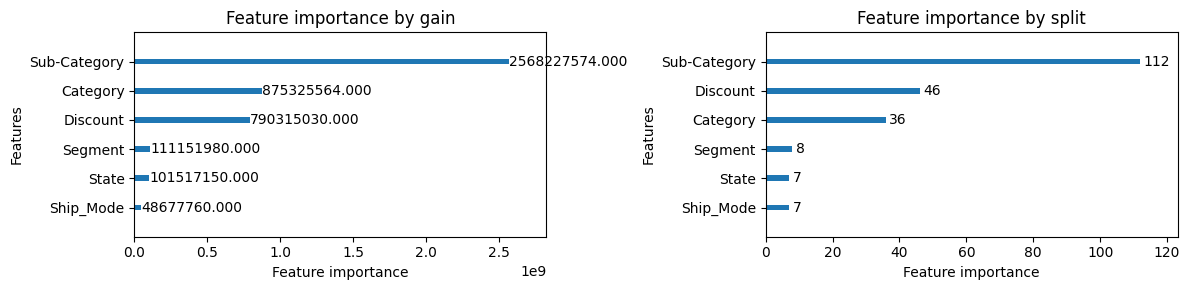

In [40]:
# Заплотим фича импортанс по сплиту и по гейну. 
fig, axs = plt.subplots(
    ncols = 2, 
    nrows = 1, 
    figsize = (12, 3)
)

lgb.plot_importance(
    model, 
    importance_type = 'gain', 
    grid = False, 
    ax = axs[0]
)

lgb.plot_importance(
    model, 
    importance_type = 'split', 
    grid = False,
    ax = axs[1]
)

axs[0].set_title('Feature importance by gain')
axs[1].set_title('Feature importance by split')

plt.tight_layout()
plt.show()

Как видим, вклад в предикт меньше всего вносят фичи Segment, State, Ship_Mode. То есть ожидаемая выручка от заказа слабо зависит от типа доставки, штата и типа покупателя.

Теперь построим бустинг для предсказания прибыли.

In [44]:
# Разобьем выборку на тренировочную, валидационную и тестовую.
X_train, X_test, y_train, y_test = train_test_split(df_boosting, target_profit, test_size = 0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25)

In [45]:
# Подберем гипер параметры
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),  # ставим лог = тру чтобы лучше перебирать лернинг рейты
        'num_leaves': trial.suggest_int('num_leaves', 10, 120),
        'n_estimators': trial.suggest_int('n_estimators', 10, 100)
    }
    
    model = LGBMRegressor(**params)
    model.fit(
        X=X_train, 
        y=y_train
    )
    
    preds = model.predict(X_val)
    mse_valid = mean_squared_error(
        y_true=y_val, 
        y_pred=preds
    )
    
    return mse_valid

In [47]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=200)

[I 2024-06-09 01:13:37,793] A new study created in memory with name: no-name-5c90e8af-1eec-4cf4-a17b-65cd41eb6572


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:13:38,041] Trial 0 finished with value: 17341.39156005267 and parameters: {'learning_rate': 0.09457426747649582, 'num_leaves': 67, 'n_estimators': 85}. Best is trial 0 with value: 17341.39156005267.
[I 2024-06-09 01:13:38,120] Trial 1 finished with value: 13629.687887045373 and parameters: {'learning_rate': 0.0091200761689646, 'num_leaves': 31, 'n_estimators': 28}. Best is trial 1 with value: 13629.687887045373.
[I 2024-06-09 01:13:38,241] Trial 2 finished with value: 13207.637696871128 and parameters: {'learning_rate': 0.005140000905068416, 'num_leaves': 20, 'n_estimators': 76}. Best is trial 2 with value: 13207.637696871128.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000983 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing 

[I 2024-06-09 01:13:38,534] Trial 3 finished with value: 14222.47996724675 and parameters: {'learning_rate': 0.00173921608898752, 'num_leaves': 77, 'n_estimators': 94}. Best is trial 2 with value: 13207.637696871128.
[I 2024-06-09 01:13:38,599] Trial 4 finished with value: 14888.297845191022 and parameters: {'learning_rate': 0.004130986967952942, 'num_leaves': 43, 'n_estimators': 20}. Best is trial 2 with value: 13207.637696871128.
[I 2024-06-09 01:13:38,639] Trial 5 finished with value: 14012.751635976498 and parameters: {'learning_rate': 0.12021653688635314, 'num_leaves': 24, 'n_estimators': 11}. Best is trial 2 with value: 13207.637696871128.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000933 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000156 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] 

[I 2024-06-09 01:13:38,763] Trial 6 finished with value: 14946.448139165896 and parameters: {'learning_rate': 0.03444876206458636, 'num_leaves': 25, 'n_estimators': 72}. Best is trial 2 with value: 13207.637696871128.
[I 2024-06-09 01:13:38,879] Trial 7 finished with value: 13363.846560366273 and parameters: {'learning_rate': 0.019390072778105224, 'num_leaves': 25, 'n_estimators': 56}. Best is trial 2 with value: 13207.637696871128.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:13:39,316] Trial 8 finished with value: 14396.986253288282 and parameters: {'learning_rate': 0.0014115008394798025, 'num_leaves': 101, 'n_estimators': 99}. Best is trial 2 with value: 13207.637696871128.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000898 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:13:39,538] Trial 9 finished with value: 13078.221641025422 and parameters: {'learning_rate': 0.005664624543974208, 'num_leaves': 44, 'n_estimators': 76}. Best is trial 9 with value: 13078.221641025422.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:13:39,849] Trial 10 finished with value: 14252.603100489116 and parameters: {'learning_rate': 0.027823893073374857, 'num_leaves': 115, 'n_estimators': 48}. Best is trial 9 with value: 13078.221641025422.
[I 2024-06-09 01:13:40,067] Trial 11 finished with value: 13177.704603666056 and parameters: {'learning_rate': 0.005323740753700669, 'num_leaves': 49, 'n_estimators': 71}. Best is trial 9 with value: 13078.221641025422.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000916 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:13:40,260] Trial 12 finished with value: 13753.43335458859 and parameters: {'learning_rate': 0.00407617178114145, 'num_leaves': 50, 'n_estimators': 57}. Best is trial 9 with value: 13078.221641025422.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000830 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:13:40,532] Trial 13 finished with value: 12960.45573693253 and parameters: {'learning_rate': 0.010161028058145106, 'num_leaves': 52, 'n_estimators': 69}. Best is trial 13 with value: 12960.45573693253.
[I 2024-06-09 01:13:40,711] Trial 14 finished with value: 13118.968096487044 and parameters: {'learning_rate': 0.011020797028000412, 'num_leaves': 82, 'n_estimators': 38}. Best is trial 13 with value: 12960.45573693253.
[I 2024-06-09 01:13:40,828] Trial 15 finished with value: 16276.931098316922 and parameters: {'learning_rate': 0.2936638339257877, 'num_leaves': 10, 'n_estimators': 62}. Best is trial 13 with value: 12960.45573693253.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000895 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing 

[I 2024-06-09 01:13:41,062] Trial 16 finished with value: 14097.5181818401 and parameters: {'learning_rate': 0.00223305734340488, 'num_leaves': 57, 'n_estimators': 81}. Best is trial 13 with value: 12960.45573693253.
[I 2024-06-09 01:13:41,315] Trial 17 finished with value: 16253.092103527528 and parameters: {'learning_rate': 0.046874600153547316, 'num_leaves': 40, 'n_estimators': 88}. Best is trial 13 with value: 12960.45573693253.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:13:41,533] Trial 18 finished with value: 12960.262603980209 and parameters: {'learning_rate': 0.010507207926333185, 'num_leaves': 65, 'n_estimators': 64}. Best is trial 18 with value: 12960.262603980209.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:13:41,726] Trial 19 finished with value: 12994.513334053432 and parameters: {'learning_rate': 0.011275133692082521, 'num_leaves': 89, 'n_estimators': 48}. Best is trial 18 with value: 12960.262603980209.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


[I 2024-06-09 01:13:41,967] Trial 20 finished with value: 13568.376266901529 and parameters: {'learning_rate': 0.01599089528112353, 'num_leaves': 65, 'n_estimators': 66}. Best is trial 18 with value: 12960.262603980209.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:13:42,153] Trial 21 finished with value: 13061.75413289806 and parameters: {'learning_rate': 0.010164004050527364, 'num_leaves': 83, 'n_estimators': 46}. Best is trial 18 with value: 12960.262603980209.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000873 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000158 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:13:42,339] Trial 22 finished with value: 13008.591827212014 and parameters: {'learning_rate': 0.015513654939551263, 'num_leaves': 93, 'n_estimators': 44}. Best is trial 18 with value: 12960.262603980209.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000160 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:13:42,582] Trial 23 finished with value: 13035.95014968658 and parameters: {'learning_rate': 0.007583683736808823, 'num_leaves': 72, 'n_estimators': 65}. Best is trial 18 with value: 12960.262603980209.
[I 2024-06-09 01:13:42,750] Trial 24 finished with value: 14924.104190117467 and parameters: {'learning_rate': 0.0024838730326741413, 'num_leaves': 93, 'n_estimators': 32}. Best is trial 18 with value: 12960.262603980209.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000482 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:13:42,940] Trial 25 finished with value: 14200.271995723353 and parameters: {'learning_rate': 0.02607012029529467, 'num_leaves': 59, 'n_estimators': 52}. Best is trial 18 with value: 12960.262603980209.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000696 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:13:43,188] Trial 26 finished with value: 16284.692303057282 and parameters: {'learning_rate': 0.06678671279062004, 'num_leaves': 108, 'n_estimators': 60}. Best is trial 18 with value: 12960.262603980209.
[I 2024-06-09 01:13:43,354] Trial 27 finished with value: 14465.499954096578 and parameters: {'learning_rate': 0.0031918556963074353, 'num_leaves': 90, 'n_estimators': 41}. Best is trial 18 with value: 12960.262603980209.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000924 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000870 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:13:43,519] Trial 28 finished with value: 13027.519978279162 and parameters: {'learning_rate': 0.01473633620698908, 'num_leaves': 57, 'n_estimators': 52}. Best is trial 18 with value: 12960.262603980209.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:13:43,759] Trial 29 finished with value: 12951.346849292375 and parameters: {'learning_rate': 0.00750171793288708, 'num_leaves': 71, 'n_estimators': 82}. Best is trial 29 with value: 12951.346849292375.
[I 2024-06-09 01:13:44,003] Trial 30 finished with value: 14817.139551302767 and parameters: {'learning_rate': 0.021076760437723892, 'num_leaves': 67, 'n_estimators': 86}. Best is trial 29 with value: 12951.346849292375.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:13:44,227] Trial 31 finished with value: 12940.770460999505 and parameters: {'learning_rate': 0.007280691575562154, 'num_leaves': 68, 'n_estimators': 80}. Best is trial 31 with value: 12940.770460999505.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:13:44,471] Trial 32 finished with value: 12955.30127017739 and parameters: {'learning_rate': 0.007595428479766419, 'num_leaves': 73, 'n_estimators': 81}. Best is trial 31 with value: 12940.770460999505.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000917 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:13:44,726] Trial 33 finished with value: 12961.762129165938 and parameters: {'learning_rate': 0.007072148850695061, 'num_leaves': 71, 'n_estimators': 80}. Best is trial 31 with value: 12940.770460999505.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:13:45,001] Trial 34 finished with value: 13006.141374144343 and parameters: {'learning_rate': 0.00761601084411946, 'num_leaves': 77, 'n_estimators': 92}. Best is trial 31 with value: 12940.770460999505.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:13:45,220] Trial 35 finished with value: 13763.463105259958 and parameters: {'learning_rate': 0.002919178440785621, 'num_leaves': 63, 'n_estimators': 80}. Best is trial 31 with value: 12940.770460999505.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:13:45,490] Trial 36 finished with value: 13221.836096352592 and parameters: {'learning_rate': 0.003999829217859816, 'num_leaves': 75, 'n_estimators': 93}. Best is trial 31 with value: 12940.770460999505.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:13:45,749] Trial 37 finished with value: 13111.356701273306 and parameters: {'learning_rate': 0.005761302916768119, 'num_leaves': 82, 'n_estimators': 74}. Best is trial 31 with value: 12940.770460999505.
[I 2024-06-09 01:13:45,962] Trial 38 finished with value: 14074.79517152243 and parameters: {'learning_rate': 0.0018393532052786374, 'num_leaves': 36, 'n_estimators': 100}. Best is trial 31 with value: 12940.770460999505.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:13:46,188] Trial 39 finished with value: 14826.09100026276 and parameters: {'learning_rate': 0.0010828742566044048, 'num_leaves': 69, 'n_estimators': 83}. Best is trial 31 with value: 12940.770460999505.
[I 2024-06-09 01:13:46,433] Trial 40 finished with value: 13373.981730751713 and parameters: {'learning_rate': 0.01253787954091505, 'num_leaves': 64, 'n_estimators': 77}. Best is trial 31 with value: 12940.770460999505.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:13:46,621] Trial 41 finished with value: 12915.766247988799 and parameters: {'learning_rate': 0.008406939069293653, 'num_leaves': 50, 'n_estimators': 69}. Best is trial 41 with value: 12915.766247988799.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000898 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:13:46,860] Trial 42 finished with value: 12950.222554629594 and parameters: {'learning_rate': 0.007552151085608467, 'num_leaves': 60, 'n_estimators': 89}. Best is trial 41 with value: 12915.766247988799.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:13:47,124] Trial 43 finished with value: 12926.788211864054 and parameters: {'learning_rate': 0.007242461787461995, 'num_leaves': 52, 'n_estimators': 88}. Best is trial 41 with value: 12915.766247988799.
[I 2024-06-09 01:13:47,318] Trial 44 finished with value: 13205.270651092545 and parameters: {'learning_rate': 0.004191833327569797, 'num_leaves': 32, 'n_estimators': 87}. Best is trial 41 with value: 12915.766247988799.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001023 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:13:47,568] Trial 45 finished with value: 12916.154793969796 and parameters: {'learning_rate': 0.006256241699524329, 'num_leaves': 48, 'n_estimators': 97}. Best is trial 41 with value: 12915.766247988799.
[I 2024-06-09 01:13:47,811] Trial 46 finished with value: 13026.483037328608 and parameters: {'learning_rate': 0.004947195795030129, 'num_leaves': 46, 'n_estimators': 96}. Best is trial 41 with value: 12915.766247988799.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:13:48,042] Trial 47 finished with value: 12964.116261007865 and parameters: {'learning_rate': 0.006026458951607884, 'num_leaves': 54, 'n_estimators': 90}. Best is trial 41 with value: 12915.766247988799.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:13:48,279] Trial 48 finished with value: 13409.578068308092 and parameters: {'learning_rate': 0.0031820652163976025, 'num_leaves': 46, 'n_estimators': 96}. Best is trial 41 with value: 12915.766247988799.
[I 2024-06-09 01:13:48,465] Trial 49 finished with value: 13334.83679437217 and parameters: {'learning_rate': 0.0046441524070127745, 'num_leaves': 37, 'n_estimators': 70}. Best is trial 41 with value: 12915.766247988799.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000870 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:13:48,910] Trial 50 finished with value: 14860.034801139698 and parameters: {'learning_rate': 0.022113363845411283, 'num_leaves': 53, 'n_estimators': 90}. Best is trial 41 with value: 12915.766247988799.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000576 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:13:49,176] Trial 51 finished with value: 13022.882361286174 and parameters: {'learning_rate': 0.008854801132967896, 'num_leaves': 60, 'n_estimators': 85}. Best is trial 41 with value: 12915.766247988799.
[I 2024-06-09 01:13:49,392] Trial 52 finished with value: 13008.17392027533 and parameters: {'learning_rate': 0.00642312874148144, 'num_leaves': 51, 'n_estimators': 77}. Best is trial 41 with value: 12915.766247988799.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000749 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:13:49,672] Trial 53 finished with value: 13061.233426423403 and parameters: {'learning_rate': 0.008843570390015083, 'num_leaves': 39, 'n_estimators': 95}. Best is trial 41 with value: 12915.766247988799.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:13:49,931] Trial 54 finished with value: 13566.815942589312 and parameters: {'learning_rate': 0.012266879308210549, 'num_leaves': 44, 'n_estimators': 89}. Best is trial 41 with value: 12915.766247988799.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000774 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:13:50,200] Trial 55 finished with value: 13262.769662914556 and parameters: {'learning_rate': 0.003616704060800443, 'num_leaves': 61, 'n_estimators': 97}. Best is trial 41 with value: 12915.766247988799.
[I 2024-06-09 01:13:50,302] Trial 56 finished with value: 14863.310088352438 and parameters: {'learning_rate': 0.0053375762341821, 'num_leaves': 56, 'n_estimators': 16}. Best is trial 41 with value: 12915.766247988799.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000661 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:13:50,618] Trial 57 finished with value: 13702.363238018146 and parameters: {'learning_rate': 0.013714710195766333, 'num_leaves': 48, 'n_estimators': 83}. Best is trial 41 with value: 12915.766247988799.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000322 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:13:50,892] Trial 58 finished with value: 12974.910421299901 and parameters: {'learning_rate': 0.008987048583449456, 'num_leaves': 79, 'n_estimators': 73}. Best is trial 41 with value: 12915.766247988799.
[I 2024-06-09 01:13:51,063] Trial 59 finished with value: 17371.428008637253 and parameters: {'learning_rate': 0.1568696812041509, 'num_leaves': 32, 'n_estimators': 68}. Best is trial 41 with value: 12915.766247988799.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:13:51,301] Trial 60 finished with value: 14483.657827031406 and parameters: {'learning_rate': 0.017677292732210945, 'num_leaves': 42, 'n_estimators': 92}. Best is trial 41 with value: 12915.766247988799.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000721 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:13:51,568] Trial 61 finished with value: 12962.18804120309 and parameters: {'learning_rate': 0.007585484069043716, 'num_leaves': 74, 'n_estimators': 83}. Best is trial 41 with value: 12915.766247988799.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:13:51,848] Trial 62 finished with value: 13010.418876973092 and parameters: {'learning_rate': 0.0065140444814291674, 'num_leaves': 71, 'n_estimators': 81}. Best is trial 41 with value: 12915.766247988799.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000870 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:13:52,131] Trial 63 finished with value: 12955.008500332513 and parameters: {'learning_rate': 0.008459502907233933, 'num_leaves': 67, 'n_estimators': 76}. Best is trial 41 with value: 12915.766247988799.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000718 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:13:52,409] Trial 64 finished with value: 13060.73597406493 and parameters: {'learning_rate': 0.010142919899733555, 'num_leaves': 67, 'n_estimators': 76}. Best is trial 41 with value: 12915.766247988799.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:13:52,708] Trial 65 finished with value: 13133.710927497285 and parameters: {'learning_rate': 0.004717748299825097, 'num_leaves': 61, 'n_estimators': 86}. Best is trial 41 with value: 12915.766247988799.
[I 2024-06-09 01:13:52,971] Trial 66 finished with value: 13173.597565029451 and parameters: {'learning_rate': 0.008784484357039041, 'num_leaves': 51, 'n_estimators': 99}. Best is trial 41 with value: 12915.766247988799.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:13:53,214] Trial 67 finished with value: 14037.45945431061 and parameters: {'learning_rate': 0.0026187470965562095, 'num_leaves': 68, 'n_estimators': 73}. Best is trial 41 with value: 12915.766247988799.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:13:53,390] Trial 68 finished with value: 12960.616949865165 and parameters: {'learning_rate': 0.011986220815115375, 'num_leaves': 56, 'n_estimators': 59}. Best is trial 41 with value: 12915.766247988799.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:13:53,595] Trial 69 finished with value: 13675.306582210598 and parameters: {'learning_rate': 0.0037230499549666296, 'num_leaves': 79, 'n_estimators': 67}. Best is trial 41 with value: 12915.766247988799.
[I 2024-06-09 01:13:53,753] Trial 70 finished with value: 13055.23834263102 and parameters: {'learning_rate': 0.005747461496386135, 'num_leaves': 28, 'n_estimators': 78}. Best is trial 41 with value: 12915.766247988799.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000177 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000815 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:13:54,056] Trial 71 finished with value: 13025.412485627814 and parameters: {'learning_rate': 0.006438017163645458, 'num_leaves': 86, 'n_estimators': 81}. Best is trial 41 with value: 12915.766247988799.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000941 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:13:54,328] Trial 72 finished with value: 12962.13896604164 and parameters: {'learning_rate': 0.007664714086179249, 'num_leaves': 64, 'n_estimators': 88}. Best is trial 41 with value: 12915.766247988799.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:13:54,638] Trial 73 finished with value: 13335.233649990349 and parameters: {'learning_rate': 0.010158522175824494, 'num_leaves': 72, 'n_estimators': 91}. Best is trial 41 with value: 12915.766247988799.
[I 2024-06-09 01:13:54,877] Trial 74 finished with value: 12924.677270436281 and parameters: {'learning_rate': 0.007381788012930512, 'num_leaves': 58, 'n_estimators': 84}. Best is trial 41 with value: 12915.766247988799.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:13:55,146] Trial 75 finished with value: 14174.950257710374 and parameters: {'learning_rate': 0.015968353491495283, 'num_leaves': 59, 'n_estimators': 85}. Best is trial 41 with value: 12915.766247988799.
[I 2024-06-09 01:13:55,314] Trial 76 finished with value: 13214.661650609753 and parameters: {'learning_rate': 0.0052713443234650575, 'num_leaves': 18, 'n_estimators': 79}. Best is trial 41 with value: 12915.766247988799.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:13:55,557] Trial 77 finished with value: 15843.533656996371 and parameters: {'learning_rate': 0.037008320221752725, 'num_leaves': 48, 'n_estimators': 94}. Best is trial 41 with value: 12915.766247988799.
[I 2024-06-09 01:13:55,774] Trial 78 finished with value: 13431.92657696843 and parameters: {'learning_rate': 0.013590623886571944, 'num_leaves': 54, 'n_estimators': 74}. Best is trial 41 with value: 12915.766247988799.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000895 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:13:55,985] Trial 79 finished with value: 13352.974408583981 and parameters: {'learning_rate': 0.004550204540578938, 'num_leaves': 58, 'n_estimators': 71}. Best is trial 41 with value: 12915.766247988799.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000807 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:13:56,191] Trial 80 finished with value: 13028.457193808623 and parameters: {'learning_rate': 0.00789014414160154, 'num_leaves': 63, 'n_estimators': 63}. Best is trial 41 with value: 12915.766247988799.
[I 2024-06-09 01:13:56,458] Trial 81 finished with value: 13232.551573809928 and parameters: {'learning_rate': 0.010597511961239278, 'num_leaves': 75, 'n_estimators': 82}. Best is trial 41 with value: 12915.766247988799.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000884 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:13:56,734] Trial 82 finished with value: 12951.120783249335 and parameters: {'learning_rate': 0.0064714741396945255, 'num_leaves': 67, 'n_estimators': 88}. Best is trial 41 with value: 12915.766247988799.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000830 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:13:56,991] Trial 83 finished with value: 12945.188331584239 and parameters: {'learning_rate': 0.006816910935270004, 'num_leaves': 69, 'n_estimators': 88}. Best is trial 41 with value: 12915.766247988799.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000673 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:13:57,259] Trial 84 finished with value: 13026.563023127339 and parameters: {'learning_rate': 0.005878466681236153, 'num_leaves': 70, 'n_estimators': 87}. Best is trial 41 with value: 12915.766247988799.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000877 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:13:57,519] Trial 85 finished with value: 12934.549753905312 and parameters: {'learning_rate': 0.006761150052689057, 'num_leaves': 55, 'n_estimators': 98}. Best is trial 41 with value: 12915.766247988799.
[I 2024-06-09 01:13:57,773] Trial 86 finished with value: 12940.448826524196 and parameters: {'learning_rate': 0.0068676612684789844, 'num_leaves': 54, 'n_estimators': 98}. Best is trial 41 with value: 12915.766247988799.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:13:58,051] Trial 87 finished with value: 13222.988384834009 and parameters: {'learning_rate': 0.0036875018597803027, 'num_leaves': 46, 'n_estimators': 98}. Best is trial 41 with value: 12915.766247988799.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:13:58,325] Trial 88 finished with value: 13138.132254440075 and parameters: {'learning_rate': 0.004235866292499011, 'num_leaves': 55, 'n_estimators': 95}. Best is trial 41 with value: 12915.766247988799.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:13:58,590] Trial 89 finished with value: 12948.17514125929 and parameters: {'learning_rate': 0.0069673460586888985, 'num_leaves': 50, 'n_estimators': 99}. Best is trial 41 with value: 12915.766247988799.
[I 2024-06-09 01:13:58,827] Trial 90 finished with value: 13234.05668505256 and parameters: {'learning_rate': 0.009771035162016552, 'num_leaves': 50, 'n_estimators': 93}. Best is trial 41 with value: 12915.766247988799.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000891 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:13:59,047] Trial 91 finished with value: 12914.031691840544 and parameters: {'learning_rate': 0.006757341888047247, 'num_leaves': 42, 'n_estimators': 100}. Best is trial 91 with value: 12914.031691840544.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:13:59,288] Trial 92 finished with value: 12973.935561180277 and parameters: {'learning_rate': 0.005239078728970765, 'num_leaves': 41, 'n_estimators': 100}. Best is trial 91 with value: 12914.031691840544.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:13:59,539] Trial 93 finished with value: 12929.333613447556 and parameters: {'learning_rate': 0.006738292985563023, 'num_leaves': 52, 'n_estimators': 97}. Best is trial 91 with value: 12914.031691840544.
[I 2024-06-09 01:13:59,754] Trial 94 finished with value: 13563.95753076001 and parameters: {'learning_rate': 0.011521306961930844, 'num_leaves': 35, 'n_estimators': 98}. Best is trial 91 with value: 12914.031691840544.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000917 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:14:00,029] Trial 95 finished with value: 13036.355611299941 and parameters: {'learning_rate': 0.0048690318799713755, 'num_leaves': 45, 'n_estimators': 96}. Best is trial 91 with value: 12914.031691840544.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:14:00,282] Trial 96 finished with value: 13497.850950218479 and parameters: {'learning_rate': 0.0031056952220567227, 'num_leaves': 53, 'n_estimators': 92}. Best is trial 91 with value: 12914.031691840544.
[I 2024-06-09 01:14:00,502] Trial 97 finished with value: 12887.554948496389 and parameters: {'learning_rate': 0.007057676107116627, 'num_leaves': 38, 'n_estimators': 94}. Best is trial 97 with value: 12887.554948496389.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:14:00,896] Trial 98 finished with value: 13127.81087903398 and parameters: {'learning_rate': 0.00823383720878411, 'num_leaves': 120, 'n_estimators': 95}. Best is trial 97 with value: 12887.554948496389.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000891 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:14:01,142] Trial 99 finished with value: 13229.1925749132 and parameters: {'learning_rate': 0.0093026247749624, 'num_leaves': 42, 'n_estimators': 100}. Best is trial 97 with value: 12887.554948496389.
[I 2024-06-09 01:14:01,371] Trial 100 finished with value: 12882.63319826765 and parameters: {'learning_rate': 0.0059871251751589544, 'num_leaves': 34, 'n_estimators': 97}. Best is trial 100 with value: 12882.63319826765.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000578 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:14:01,598] Trial 101 finished with value: 12881.926221965607 and parameters: {'learning_rate': 0.005914386140706564, 'num_leaves': 38, 'n_estimators': 98}. Best is trial 101 with value: 12881.926221965607.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:14:01,821] Trial 102 finished with value: 12923.968685939028 and parameters: {'learning_rate': 0.0056948533433486045, 'num_leaves': 39, 'n_estimators': 97}. Best is trial 101 with value: 12881.926221965607.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:14:02,048] Trial 103 finished with value: 12904.401598821432 and parameters: {'learning_rate': 0.006056473052806105, 'num_leaves': 39, 'n_estimators': 93}. Best is trial 101 with value: 12881.926221965607.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:14:02,258] Trial 104 finished with value: 12948.865801202015 and parameters: {'learning_rate': 0.005757334208685236, 'num_leaves': 35, 'n_estimators': 93}. Best is trial 101 with value: 12881.926221965607.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000953 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000876 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:14:02,452] Trial 105 finished with value: 13171.470691952767 and parameters: {'learning_rate': 0.004233316447676044, 'num_leaves': 29, 'n_estimators': 91}. Best is trial 101 with value: 12881.926221965607.
[I 2024-06-09 01:14:02,680] Trial 106 finished with value: 12944.488041233255 and parameters: {'learning_rate': 0.005553397506877421, 'num_leaves': 38, 'n_estimators': 96}. Best is trial 101 with value: 12881.926221965607.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:14:02,891] Trial 107 finished with value: 13262.736089068772 and parameters: {'learning_rate': 0.0036904549635036117, 'num_leaves': 40, 'n_estimators': 94}. Best is trial 101 with value: 12881.926221965607.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000895 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:14:03,065] Trial 108 finished with value: 13130.561261195564 and parameters: {'learning_rate': 0.00464028683739053, 'num_leaves': 22, 'n_estimators': 90}. Best is trial 101 with value: 12881.926221965607.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000911 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:14:03,271] Trial 109 finished with value: 12874.971399302834 and parameters: {'learning_rate': 0.006239968660302956, 'num_leaves': 33, 'n_estimators': 97}. Best is trial 109 with value: 12874.971399302834.
[I 2024-06-09 01:14:03,387] Trial 110 finished with value: 14820.637406211834 and parameters: {'learning_rate': 0.0033354163703991396, 'num_leaves': 33, 'n_estimators': 27}. Best is trial 109 with value: 12874.971399302834.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000929 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:14:03,606] Trial 111 finished with value: 12901.437676822634 and parameters: {'learning_rate': 0.006170803222619178, 'num_leaves': 44, 'n_estimators': 97}. Best is trial 109 with value: 12874.971399302834.
[I 2024-06-09 01:14:03,825] Trial 112 finished with value: 12907.78591060591 and parameters: {'learning_rate': 0.005920691120134635, 'num_leaves': 38, 'n_estimators': 94}. Best is trial 109 with value: 12874.971399302834.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000590 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:14:04,038] Trial 113 finished with value: 12849.491736344822 and parameters: {'learning_rate': 0.0060003189801001115, 'num_leaves': 29, 'n_estimators': 100}. Best is trial 113 with value: 12849.491736344822.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000797 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86


[I 2024-06-09 01:14:04,240] Trial 114 finished with value: 12854.179003495794 and parameters: {'learning_rate': 0.006017801057426685, 'num_leaves': 27, 'n_estimators': 100}. Best is trial 113 with value: 12849.491736344822.


[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000867 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:14:04,440] Trial 115 finished with value: 12913.699442696983 and parameters: {'learning_rate': 0.005137963899270516, 'num_leaves': 26, 'n_estimators': 100}. Best is trial 113 with value: 12849.491736344822.
[I 2024-06-09 01:14:04,628] Trial 116 finished with value: 12949.560939901534 and parameters: {'learning_rate': 0.0051357695301167, 'num_leaves': 26, 'n_estimators': 94}. Best is trial 113 with value: 12849.491736344822.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000911 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:14:04,796] Trial 117 finished with value: 13322.205996374387 and parameters: {'learning_rate': 0.004237455296611874, 'num_leaves': 17, 'n_estimators': 100}. Best is trial 113 with value: 12849.491736344822.
[I 2024-06-09 01:14:04,999] Trial 118 finished with value: 13518.410295856896 and parameters: {'learning_rate': 0.002803010166094404, 'num_leaves': 30, 'n_estimators': 100}. Best is trial 113 with value: 12849.491736344822.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:14:05,135] Trial 119 finished with value: 13611.523349628804 and parameters: {'learning_rate': 0.0050731536831577695, 'num_leaves': 26, 'n_estimators': 53}. Best is trial 113 with value: 12849.491736344822.
[I 2024-06-09 01:14:05,301] Trial 120 finished with value: 13897.321969342596 and parameters: {'learning_rate': 0.002271402431992456, 'num_leaves': 23, 'n_estimators': 95}. Best is trial 113 with value: 12849.491736344822.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000991 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:14:05,503] Trial 121 finished with value: 12883.097501025955 and parameters: {'learning_rate': 0.005869527894956702, 'num_leaves': 33, 'n_estimators': 97}. Best is trial 113 with value: 12849.491736344822.
[I 2024-06-09 01:14:05,730] Trial 122 finished with value: 12878.135337724183 and parameters: {'learning_rate': 0.006107759579443562, 'num_leaves': 34, 'n_estimators': 98}. Best is trial 113 with value: 12849.491736344822.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:14:05,948] Trial 123 finished with value: 12889.376079082835 and parameters: {'learning_rate': 0.00580552650927883, 'num_leaves': 33, 'n_estimators': 97}. Best is trial 113 with value: 12849.491736344822.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000981 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:14:06,164] Trial 124 finished with value: 12916.542654644816 and parameters: {'learning_rate': 0.005884767110110768, 'num_leaves': 33, 'n_estimators': 92}. Best is trial 113 with value: 12849.491736344822.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:14:06,355] Trial 125 finished with value: 13078.667860498048 and parameters: {'learning_rate': 0.004507407075071766, 'num_leaves': 28, 'n_estimators': 97}. Best is trial 113 with value: 12849.491736344822.
[I 2024-06-09 01:14:06,554] Trial 126 finished with value: 13016.250232410634 and parameters: {'learning_rate': 0.004953027060227267, 'num_leaves': 36, 'n_estimators': 94}. Best is trial 113 with value: 12849.491736344822.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:14:06,736] Trial 127 finished with value: 12948.245903846362 and parameters: {'learning_rate': 0.006101694454884441, 'num_leaves': 20, 'n_estimators': 98}. Best is trial 113 with value: 12849.491736344822.
[I 2024-06-09 01:14:06,938] Trial 128 finished with value: 13169.837961706115 and parameters: {'learning_rate': 0.003965662906663985, 'num_leaves': 31, 'n_estimators': 96}. Best is trial 113 with value: 12849.491736344822.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000666 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:14:07,139] Trial 129 finished with value: 12935.351759581064 and parameters: {'learning_rate': 0.008332026913557665, 'num_leaves': 34, 'n_estimators': 91}. Best is trial 113 with value: 12849.491736344822.
[I 2024-06-09 01:14:07,350] Trial 130 finished with value: 12982.011578454534 and parameters: {'learning_rate': 0.005437888217570696, 'num_leaves': 38, 'n_estimators': 93}. Best is trial 113 with value: 12849.491736344822.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:14:07,535] Trial 131 finished with value: 12843.389956840318 and parameters: {'learning_rate': 0.006130910415631947, 'num_leaves': 27, 'n_estimators': 100}. Best is trial 131 with value: 12843.389956840318.
[I 2024-06-09 01:14:07,739] Trial 132 finished with value: 12841.972532176393 and parameters: {'learning_rate': 0.006133851714573013, 'num_leaves': 27, 'n_estimators': 98}. Best is trial 132 with value: 12841.972532176393.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:14:07,971] Trial 133 finished with value: 12850.647563701119 and parameters: {'learning_rate': 0.006089891167079066, 'num_leaves': 30, 'n_estimators': 98}. Best is trial 132 with value: 12841.972532176393.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000927 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:14:08,183] Trial 134 finished with value: 12939.572605469526 and parameters: {'learning_rate': 0.00763872515029233, 'num_leaves': 24, 'n_estimators': 98}. Best is trial 132 with value: 12841.972532176393.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:14:08,457] Trial 135 finished with value: 12858.766953029934 and parameters: {'learning_rate': 0.006325251560955235, 'num_leaves': 31, 'n_estimators': 96}. Best is trial 132 with value: 12841.972532176393.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:14:08,760] Trial 136 finished with value: 13064.089685068384 and parameters: {'learning_rate': 0.009189768958112564, 'num_leaves': 30, 'n_estimators': 96}. Best is trial 132 with value: 12841.972532176393.
[I 2024-06-09 01:14:08,995] Trial 137 finished with value: 13605.608177815526 and parameters: {'learning_rate': 0.0033996247382923634, 'num_leaves': 15, 'n_estimators': 98}. Best is trial 132 with value: 12841.972532176393.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:14:09,268] Trial 138 finished with value: 12920.921447278799 and parameters: {'learning_rate': 0.00807671582869743, 'num_leaves': 28, 'n_estimators': 96}. Best is trial 132 with value: 12841.972532176393.
[I 2024-06-09 01:14:09,545] Trial 139 finished with value: 13054.089572564499 and parameters: {'learning_rate': 0.004458753119270959, 'num_leaves': 32, 'n_estimators': 99}. Best is trial 132 with value: 12841.972532176393.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000933 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:14:09,864] Trial 140 finished with value: 12918.147623332961 and parameters: {'learning_rate': 0.00730028290771907, 'num_leaves': 36, 'n_estimators': 100}. Best is trial 132 with value: 12841.972532176393.
[I 2024-06-09 01:14:10,111] Trial 141 finished with value: 12861.061485893566 and parameters: {'learning_rate': 0.006444962344207829, 'num_leaves': 31, 'n_estimators': 95}. Best is trial 132 with value: 12841.972532176393.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:14:10,304] Trial 142 finished with value: 12921.110237369026 and parameters: {'learning_rate': 0.006515288304671375, 'num_leaves': 21, 'n_estimators': 95}. Best is trial 132 with value: 12841.972532176393.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000946 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:14:10,495] Trial 143 finished with value: 12853.412857502954 and parameters: {'learning_rate': 0.0063366754066028624, 'num_leaves': 27, 'n_estimators': 97}. Best is trial 132 with value: 12841.972532176393.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:14:10,703] Trial 144 finished with value: 12929.380459106784 and parameters: {'learning_rate': 0.005325871237359592, 'num_leaves': 25, 'n_estimators': 98}. Best is trial 132 with value: 12841.972532176393.
[I 2024-06-09 01:14:10,912] Trial 145 finished with value: 13056.013625443959 and parameters: {'learning_rate': 0.004801839068101735, 'num_leaves': 30, 'n_estimators': 92}. Best is trial 132 with value: 12841.972532176393.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:14:11,108] Trial 146 finished with value: 13270.940199621773 and parameters: {'learning_rate': 0.003932006046012902, 'num_leaves': 27, 'n_estimators': 90}. Best is trial 132 with value: 12841.972532176393.
[I 2024-06-09 01:14:11,313] Trial 147 finished with value: 12877.487045256288 and parameters: {'learning_rate': 0.00697515540644528, 'num_leaves': 33, 'n_estimators': 95}. Best is trial 132 with value: 12841.972532176393.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000974 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000793 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:14:11,517] Trial 148 finished with value: 12868.765709868945 and parameters: {'learning_rate': 0.006962219731485819, 'num_leaves': 31, 'n_estimators': 95}. Best is trial 132 with value: 12841.972532176393.
[I 2024-06-09 01:14:11,709] Trial 149 finished with value: 13048.806839228195 and parameters: {'learning_rate': 0.009254417083474699, 'num_leaves': 24, 'n_estimators': 95}. Best is trial 132 with value: 12841.972532176393.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000998 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:14:11,905] Trial 150 finished with value: 17029.16229392475 and parameters: {'learning_rate': 0.08302518617216346, 'num_leaves': 31, 'n_estimators': 99}. Best is trial 132 with value: 12841.972532176393.
[I 2024-06-09 01:14:12,147] Trial 151 finished with value: 12897.947009764832 and parameters: {'learning_rate': 0.007549773090612394, 'num_leaves': 34, 'n_estimators': 95}. Best is trial 132 with value: 12841.972532176393.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:14:12,334] Trial 152 finished with value: 12863.005636206186 and parameters: {'learning_rate': 0.006843290998273801, 'num_leaves': 29, 'n_estimators': 100}. Best is trial 132 with value: 12841.972532176393.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000643 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:14:12,537] Trial 153 finished with value: 12866.978929010978 and parameters: {'learning_rate': 0.006918269195707941, 'num_leaves': 28, 'n_estimators': 100}. Best is trial 132 with value: 12841.972532176393.
[I 2024-06-09 01:14:12,755] Trial 154 finished with value: 12974.792499718851 and parameters: {'learning_rate': 0.008337751435666604, 'num_leaves': 28, 'n_estimators': 100}. Best is trial 132 with value: 12841.972532176393.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000992 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000959 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:14:12,975] Trial 155 finished with value: 13363.692413049292 and parameters: {'learning_rate': 0.010689643338448615, 'num_leaves': 29, 'n_estimators': 100}. Best is trial 132 with value: 12841.972532176393.
[I 2024-06-09 01:14:13,162] Trial 156 finished with value: 12896.727788521188 and parameters: {'learning_rate': 0.0067526078715497, 'num_leaves': 23, 'n_estimators': 98}. Best is trial 132 with value: 12841.972532176393.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000835 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:14:13,442] Trial 157 finished with value: 12995.879327254157 and parameters: {'learning_rate': 0.0065337144154026154, 'num_leaves': 18, 'n_estimators': 96}. Best is trial 132 with value: 12841.972532176393.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:14:13,681] Trial 158 finished with value: 12942.894555946748 and parameters: {'learning_rate': 0.008014090047588436, 'num_leaves': 26, 'n_estimators': 98}. Best is trial 132 with value: 12841.972532176393.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:14:13,929] Trial 159 finished with value: 14311.70240223063 and parameters: {'learning_rate': 0.0016127083811974263, 'num_leaves': 31, 'n_estimators': 93}. Best is trial 132 with value: 12841.972532176393.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:14:14,178] Trial 160 finished with value: 12968.619556656722 and parameters: {'learning_rate': 0.005221778090416812, 'num_leaves': 35, 'n_estimators': 100}. Best is trial 132 with value: 12841.972532176393.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:14:14,408] Trial 161 finished with value: 12861.13651513956 and parameters: {'learning_rate': 0.006240956970191885, 'num_leaves': 32, 'n_estimators': 97}. Best is trial 132 with value: 12841.972532176393.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000183 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:14:14,594] Trial 162 finished with value: 12862.832704896746 and parameters: {'learning_rate': 0.006965259134721138, 'num_leaves': 29, 'n_estimators': 98}. Best is trial 132 with value: 12841.972532176393.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000603 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000397 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:14:14,905] Trial 163 finished with value: 12869.779347705133 and parameters: {'learning_rate': 0.007148492162934647, 'num_leaves': 29, 'n_estimators': 96}. Best is trial 132 with value: 12841.972532176393.
[I 2024-06-09 01:14:15,110] Trial 164 finished with value: 12857.473549075297 and parameters: {'learning_rate': 0.007082995913071794, 'num_leaves': 29, 'n_estimators': 94}. Best is trial 132 with value: 12841.972532176393.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000903 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000873 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:14:15,303] Trial 165 finished with value: 13075.317840951157 and parameters: {'learning_rate': 0.009591298090409359, 'num_leaves': 28, 'n_estimators': 95}. Best is trial 132 with value: 12841.972532176393.
[I 2024-06-09 01:14:15,501] Trial 166 finished with value: 12888.63779660935 and parameters: {'learning_rate': 0.00732996213168425, 'num_leaves': 25, 'n_estimators': 91}. Best is trial 132 with value: 12841.972532176393.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000905 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:14:15,676] Trial 167 finished with value: 13001.193670834344 and parameters: {'learning_rate': 0.00863561359081776, 'num_leaves': 22, 'n_estimators': 94}. Best is trial 132 with value: 12841.972532176393.
[I 2024-06-09 01:14:15,787] Trial 168 finished with value: 13659.211453794476 and parameters: {'learning_rate': 0.007126928922901111, 'num_leaves': 30, 'n_estimators': 35}. Best is trial 132 with value: 12841.972532176393.
[I 2024-06-09 01:14:15,867] Trial 169 finished with value: 15010.672777627991 and parameters: {'learning_rate': 0.006619861570747367, 'num_leaves': 20, 'n_estimators': 11}. Best is trial 132 with value: 12841.972532176393.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing 

[I 2024-06-09 01:14:16,074] Trial 170 finished with value: 12922.364876637484 and parameters: {'learning_rate': 0.008015014913381725, 'num_leaves': 27, 'n_estimators': 96}. Best is trial 132 with value: 12841.972532176393.
[I 2024-06-09 01:14:16,280] Trial 171 finished with value: 12860.484815230671 and parameters: {'learning_rate': 0.0065604643231998265, 'num_leaves': 31, 'n_estimators': 99}. Best is trial 132 with value: 12841.972532176393.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000906 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:14:16,501] Trial 172 finished with value: 12894.5575615823 and parameters: {'learning_rate': 0.007261643541938018, 'num_leaves': 31, 'n_estimators': 100}. Best is trial 132 with value: 12841.972532176393.
[I 2024-06-09 01:14:16,697] Trial 173 finished with value: 12918.094879016224 and parameters: {'learning_rate': 0.00537798730696118, 'num_leaves': 28, 'n_estimators': 96}. Best is trial 132 with value: 12841.972532176393.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:14:16,892] Trial 174 finished with value: 12890.193708288816 and parameters: {'learning_rate': 0.0066568250224285225, 'num_leaves': 24, 'n_estimators': 98}. Best is trial 132 with value: 12841.972532176393.
[I 2024-06-09 01:14:17,089] Trial 175 finished with value: 17634.458347322972 and parameters: {'learning_rate': 0.17492638188062237, 'num_leaves': 32, 'n_estimators': 92}. Best is trial 132 with value: 12841.972532176393.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000890 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000884 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:14:17,290] Trial 176 finished with value: 13063.654564160362 and parameters: {'learning_rate': 0.008789916326336316, 'num_leaves': 30, 'n_estimators': 100}. Best is trial 132 with value: 12841.972532176393.
[I 2024-06-09 01:14:17,557] Trial 177 finished with value: 13004.665427092772 and parameters: {'learning_rate': 0.004828455269879597, 'num_leaves': 25, 'n_estimators': 94}. Best is trial 132 with value: 12841.972532176393.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000906 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:14:17,807] Trial 178 finished with value: 12848.585750190703 and parameters: {'learning_rate': 0.006324324953632286, 'num_leaves': 27, 'n_estimators': 97}. Best is trial 132 with value: 12841.972532176393.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000924 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:14:18,018] Trial 179 finished with value: 12853.519891284697 and parameters: {'learning_rate': 0.00628005382759829, 'num_leaves': 28, 'n_estimators': 98}. Best is trial 132 with value: 12841.972532176393.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:14:18,225] Trial 180 finished with value: 12868.50315846534 and parameters: {'learning_rate': 0.005617487046946799, 'num_leaves': 27, 'n_estimators': 99}. Best is trial 132 with value: 12841.972532176393.
[I 2024-06-09 01:14:18,411] Trial 181 finished with value: 12896.556055107489 and parameters: {'learning_rate': 0.005371250752040397, 'num_leaves': 27, 'n_estimators': 99}. Best is trial 132 with value: 12841.972532176393.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:14:18,621] Trial 182 finished with value: 12855.693146674435 and parameters: {'learning_rate': 0.0064207566017576425, 'num_leaves': 29, 'n_estimators': 98}. Best is trial 132 with value: 12841.972532176393.
[I 2024-06-09 01:14:18,818] Trial 183 finished with value: 12942.876180349533 and parameters: {'learning_rate': 0.005589915483706975, 'num_leaves': 21, 'n_estimators': 100}. Best is trial 132 with value: 12841.972532176393.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000879 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000903 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:14:19,010] Trial 184 finished with value: 12861.46743160428 and parameters: {'learning_rate': 0.0061739681935215965, 'num_leaves': 26, 'n_estimators': 98}. Best is trial 132 with value: 12841.972532176393.
[I 2024-06-09 01:14:19,213] Trial 185 finished with value: 13011.670743474619 and parameters: {'learning_rate': 0.004530753449726474, 'num_leaves': 26, 'n_estimators': 98}. Best is trial 132 with value: 12841.972532176393.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000891 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000882 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:14:19,402] Trial 186 finished with value: 12890.747134230338 and parameters: {'learning_rate': 0.005977174976820827, 'num_leaves': 23, 'n_estimators': 98}. Best is trial 132 with value: 12841.972532176393.
[I 2024-06-09 01:14:19,611] Trial 187 finished with value: 12920.163614512987 and parameters: {'learning_rate': 0.005121096103756729, 'num_leaves': 28, 'n_estimators': 100}. Best is trial 132 with value: 12841.972532176393.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000941 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000923 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:14:19,771] Trial 188 finished with value: 13392.505398970055 and parameters: {'learning_rate': 0.006372697508970864, 'num_leaves': 12, 'n_estimators': 97}. Best is trial 132 with value: 12841.972532176393.
[I 2024-06-09 01:14:19,972] Trial 189 finished with value: 12957.027722862298 and parameters: {'learning_rate': 0.008045075307169037, 'num_leaves': 25, 'n_estimators': 98}. Best is trial 132 with value: 12841.972532176393.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000920 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:14:20,161] Trial 190 finished with value: 12992.134864136999 and parameters: {'learning_rate': 0.004746315585159314, 'num_leaves': 23, 'n_estimators': 100}. Best is trial 132 with value: 12841.972532176393.
[I 2024-06-09 01:14:20,354] Trial 191 finished with value: 12852.668804576324 and parameters: {'learning_rate': 0.006470583719204505, 'num_leaves': 30, 'n_estimators': 96}. Best is trial 132 with value: 12841.972532176393.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6


[I 2024-06-09 01:14:20,551] Trial 192 finished with value: 12859.04260881551 and parameters: {'learning_rate': 0.006174831772010308, 'num_leaves': 29, 'n_estimators': 97}. Best is trial 132 with value: 12841.972532176393.


[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:14:20,756] Trial 193 finished with value: 12849.785387791815 and parameters: {'learning_rate': 0.006398538961618204, 'num_leaves': 29, 'n_estimators': 96}. Best is trial 132 with value: 12841.972532176393.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000904 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:14:21,119] Trial 194 finished with value: 12979.20395146607 and parameters: {'learning_rate': 0.006201765290630945, 'num_leaves': 104, 'n_estimators': 93}. Best is trial 132 with value: 12841.972532176393.
[I 2024-06-09 01:14:21,322] Trial 195 finished with value: 12863.733219978672 and parameters: {'learning_rate': 0.006108729532593428, 'num_leaves': 30, 'n_estimators': 96}. Best is trial 132 with value: 12841.972532176393.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000727 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:14:21,526] Trial 196 finished with value: 12893.203752263067 and parameters: {'learning_rate': 0.00760297896653796, 'num_leaves': 30, 'n_estimators': 97}. Best is trial 132 with value: 12841.972532176393.
[I 2024-06-09 01:14:21,709] Trial 197 finished with value: 12916.131402792618 and parameters: {'learning_rate': 0.0054639057713500964, 'num_leaves': 26, 'n_estimators': 93}. Best is trial 132 with value: 12841.972532176393.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


[I 2024-06-09 01:14:21,934] Trial 198 finished with value: 12861.078885126295 and parameters: {'learning_rate': 0.006464523560836152, 'num_leaves': 32, 'n_estimators': 96}. Best is trial 132 with value: 12841.972532176393.
[I 2024-06-09 01:14:22,169] Trial 199 finished with value: 13006.887487903501 and parameters: {'learning_rate': 0.0049871272598199885, 'num_leaves': 36, 'n_estimators': 95}. Best is trial 132 with value: 12841.972532176393.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773


In [48]:
# Посмотрим значение MSE на валидации и на тесте при оптимальных ГП.
model = LGBMRegressor(**study.best_params)
model.fit(X=X_train, y=y_train)

preds_val = model.predict(X_val)
mse_val = mean_squared_error(y_true=y_val, y_pred = preds_val)

preds_test = model.predict(X_test)
mse_test = mean_squared_error(y_true=y_test, y_pred = preds_test)
print(f'Значение MSE на валидации {mse_val}, значение MSE на тесте {mse_test}')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 6
[LightGBM] [Info] Start training from score 26.660773
Значение MSE на валидации 12841.972532176393, значение MSE на тесте 67914.04497001045


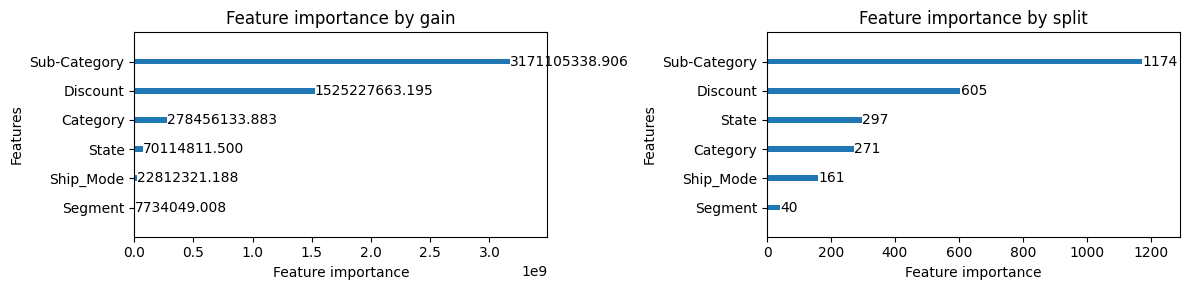

In [49]:
# Заплотим фича импортанс по сплиту и по гейну. 
fig, axs = plt.subplots(
    ncols = 2, 
    nrows = 1, 
    figsize = (12, 3)
)

lgb.plot_importance(
    model, 
    importance_type = 'gain', 
    grid = False, 
    ax = axs[0]
)

lgb.plot_importance(
    model, 
    importance_type = 'split', 
    grid = False, 
    ax = axs[1]
)

axs[0].set_title('Feature importance by gain')
axs[1].set_title('Feature importance by split')

plt.tight_layout()
plt.show()

Видим, что влияние фичей на предсказание прибыли почти такое же как и на предсказание выручки. Т.е. более всего эти показатели зависят от (под)категории товара, скидки на товар.

## Вывод

Из проведенного анализа выше анализа у меня возникли следующие предложения/замечания:
- Построить дополнительные пункты выдачи/склады в штатах с высоким спросом (Калифорния, Нью-Йорк, Техас). Эти штаты находятся достаточно далеко друг от друга, поэтому новые пункты выдачи могут хорошо обслуживать соседние штаты.
- Прибыль от продажи мебели в общей доли прибыли очень маленькая, порядка 6 процентов, при том, что доля в выручке 1/3. Стоит уточнить почему так происходит, вероятно на производство мебели фирма несет большие издержки, можно собрать дополнительные данные и изучить этот вопрос.
- Выручка, прибыль слабо зависят от типа доставки и типа покупателей.
- На центральные районы Америки приходится меньше всего выручки и продаж.
- От некоторых заказов прибыль отрицательная (иногда даже слишком), это следует подробнее изучить, собрав и проанализировав дополнительные данные. Возможно за часть заказов просто не приходит плата, а возможно магазин вынужден (или ему просто так выгодно, чтобы, например поскорее освободить склад под другой товар) продавать некоторый товар, непользующийся интересом за бесценок.